Litterature:
1. https://arxiv.org/ftp/arxiv/papers/2303/2303.09397.pdf
2. https://scholar.smu.edu/cgi/viewcontent.cgi?article=1039&context=datasciencereview
3. https://upcommons.upc.edu/bitstream/handle/2117/188441/AAALbitcoinITISE19.pdf;jsessionid=43B830DB52A8F2CE18F50C1C97A1B1D0?sequence=1

## ***Notebook Setting***

In [ ]:
! pip install emoji
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=957ac8456843b46c11b578d9a17465c09a9e21ca471f4efa45d3f36784121da5
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.0 MB/s eta 0:00:00


In [ ]:
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
import torch
from gensim.models import Word2Vec
import gensim.downloader
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import re
import emoji
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from transformers import pipeline
import math
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load the dataset
! unzip "/content/drive/MyDrive/dde-en-btc-us1822.parquet.zip"

Archive:  /content/drive/MyDrive/dde-en-btc-us1822.parquet.zip
   creating: dde-en-btc-us1822.parquet/
 extracting: dde-en-btc-us1822.parquet/_SUCCESS  
 extracting: dde-en-btc-us1822.parquet/._SUCCESS.crc  
  inflating: dde-en-btc-us1822.parquet/part-00000-959ea3bc-6e91-4a6f-bffa-eb7688dd2e6c-c000.snappy.parquet  
  inflating: dde-en-btc-us1822.parquet/.part-00000-959ea3bc-6e91-4a6f-bffa-eb7688dd2e6c-c000.snappy.parquet.crc  


In [ ]:
table = pq.read_table("/content/dde-en-btc-us1822.parquet/part-00000-959ea3bc-6e91-4a6f-bffa-eb7688dd2e6c-c000.snappy.parquet")
df = table.to_pandas()

In [ ]:
# load the already processed csv
# df = pd.read_csv("C:\\Users\\Alessandro\\Downloads\\df_modified.csv", engine='python')
df = pd.read_csv('/content/df.csv', engine='python')

# **Exploratory Data Analysis**

## ***EDA: Analysis of the dataset***

First, let's take a closer look at the structure and content of this dataset.

In [ ]:
df.head()

,id,verb,user,inreplyto,link,body,retweetbody,date,postedtime,retweetcount,...,userNumTweets,userVerified,userLanguage,userBio,country,countrycode,locality,region,subregion,locationname
0,-712159200,post,-1179232094,None,http://twitter.com/hamel1776/statuses/10011537...,South Africa investigates $80 million bitcoin ...,None,2018-05-28,2018-05-28T17:30:28.000Z,0,...,205498,False,None,Stand for liberty freedom and equal rights for...,United States,US,None,Maine,None,"Maine, United States"
1,-1735632200,post,-1642658858,None,http://twitter.com/dedramaxx1/statuses/1001165...,Bitcoin Black 3600 AirDrop $36 Value https://t...,None,2018-05-28,2018-05-28T18:18:05.000Z,0,...,13662,False,None,"Entreprenuer, Cryptocurrency Expert, Gospel Mu...",United States,US,Chesapeake,Virginia,City of Chesapeake,"Chesapeake, Virginia, United States"
2,560828400,post,-631709376,None,http://twitter.com/CoinLook/statuses/100134212...,Asian Cryptocurrency Trading Roundup: Bitcoin ...,None,2018-05-29,2018-05-29T05:59:00.000Z,0,...,126269,False,None,"Articles on #Bitcoin, #FinTech, Cryptocurrency...",United States,US,None,None,None,United States
3,-2131331600,post,-2048482217,None,http://twitter.com/pattern_crypto/statuses/100...,$BTC volume spike. 65 coin print at $7225.00. ...,None,2018-05-29,2018-05-29T11:01:19.000Z,0,...,1761,False,None,Makers of the first algo trading platform for ...,United States,US,Manhattan,New York,New York County,"Manhattan, New York, United States"
4,-331790400,post,-1814298824,None,http://twitter.com/TheAniKingdom/statuses/1001...,"RT eBTCfoundation ""We need your support commun...",None,2018-05-29,2018-05-29T15:34:09.000Z,0,...,2305,False,None,None,United States,US,None,New York,None,"New York, United States"


The dataset has 734074 rows and 27 columns.


In [ ]:
print(df.shape)

(734074, 27)


These are the details of the columns in the dataset.

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734074 entries, 0 to 734073
Data columns (total 27 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              734074 non-null  int32 
 1   verb            734074 non-null  object
 2   user            734074 non-null  int32 
 3   inreplyto       146157 non-null  object
 4   link            734074 non-null  object
 5   body            734074 non-null  object
 6   retweetbody     0 non-null       object
 7   date            734074 non-null  object
 8   postedtime      734074 non-null  object
 9   retweetcount    734074 non-null  int64 
 10  favoritescount  734074 non-null  int64 
 11  generator       734074 non-null  object
 12  twitter_lang    734074 non-null  object
 13  year            734074 non-null  object
 14  userLocation    734068 non-null  object
 15  userFriends     734074 non-null  int64 
 16  userFollowers   734074 non-null  int64 
 17  userNumTweets   734074 non-nu

Then, we identify the columns with missing values in the dataset.

Some less important columns, like "locality" and "region," contain missing values. However, this won't pose a problem as we can simply choose not to utilize these columns significantly in our project.

An interesting observation is that the language of the users and the retweet body are missing for any entry. Therefore, the "userLanguage" and "retweetbody" columns are redundant and can be removed from the dataset.



In [ ]:
print("Missing value for each column:\n", df.isnull().sum())

Missing value for each column:
 id                     0
verb                   0
user                   0
inreplyto         587917
link                   0
body                   0
retweetbody       734074
date                   0
postedtime             0
retweetcount           0
favoritescount         0
generator              0
twitter_lang           0
year                   0
userLocation           6
userFriends            0
userFollowers          0
userNumTweets          0
userVerified           0
userLanguage      734074
userBio            46382
country                0
countrycode            0
locality          368631
region            186295
subregion         380936
locationname           0
dtype: int64


In [ ]:
# remove the userLanguage column
df = df.drop("userLanguage", axis=1)
df = df.drop("retweetbody", axis=1)


We will also remove the 'verb' column as it has the same value for all rows, rendering it insignificant for our study.

In [ ]:
unique_vals_varb =df.verb.unique()
print(unique_vals_varb)

['post']


In [ ]:
# remove the userLanguage column
df = df.drop("verb", axis=1)

Next, we aimed to assess the distribution of verified and unverified users within our dataset. We observed that the number of verified users is significantly lower compared to the number of unverified users, which aligns with our expectations. This trend can be attributed to the fact that the verification process for user accounts is typically more rigorous and restricted, resulting in a smaller population of verified users.

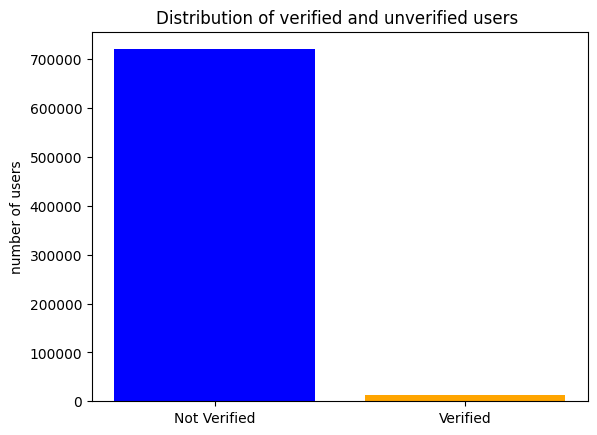

In [ ]:
verified_distr=df['userVerified'].value_counts()

plt.bar(verified_distr.index, verified_distr.values, color=['blue', 'orange'])
plt.xticks(verified_distr.index, ['Not Verified', 'Verified'])
plt.ylabel('number of users')
plt.title('Distribution of verified and unverified users ')
plt.show()

Furthermore, we aim to represent the distribution of the number of tweets from individual users. To achieve a more visually effective representation, we have opted to utilize a logarithmic scale on the tweet count. It is noteworthy that the majority of users have an average of 8-10 total tweets. This observation could be attributed to various factors, such as users who join the platform for specific events or purposes, limited engagement with the platform, or a preference for more focused and concise tweeting habits.

In [ ]:
print("The maximum number of tweets associated with a user is: ", max(df['userNumTweets']))

4160955

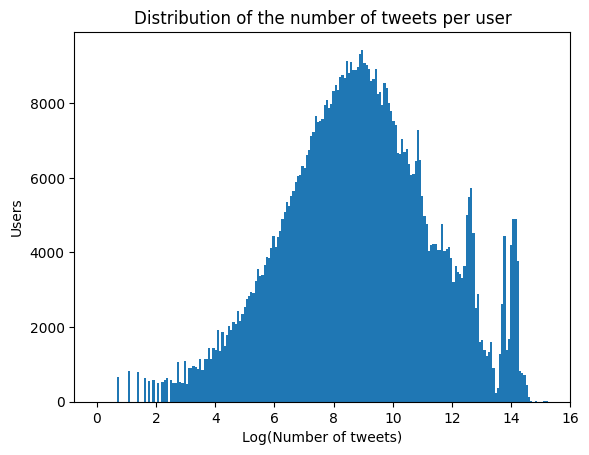

In [ ]:
plt.hist((df['userNumTweets']+1).apply(np.log), bins='auto')
plt.xlabel('Log(Number of tweets)')
plt.ylabel('Users')
plt.title('Distribution of the number of tweets per user')
plt.show()

Let's explore the distribution of tweets over the years. In recent years, there has been an increase in the number of tweets about Bitcoin. This can be attributed to the significant growth in the price of Bitcoin in 2021 and 2022, which has generated heightened interest and discussion around the topic.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
years = df['date'].dt.strftime('%Y')
years_counts = years.value_counts().sort_index()

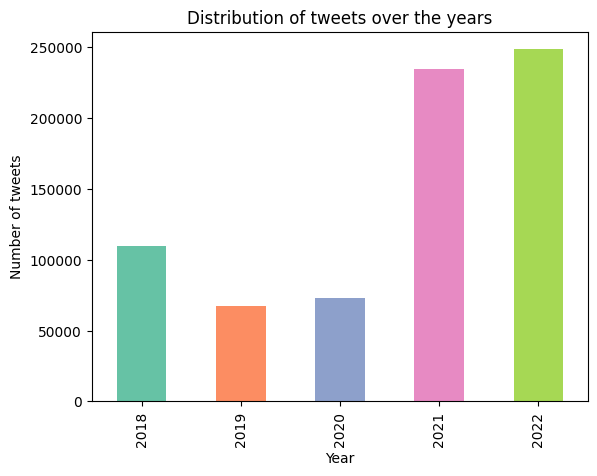

In [ ]:
num_bars = len(years_counts)
colors = sns.color_palette("Set2", n_colors=num_bars)
years_counts.plot(kind='bar', color=colors)
plt.xlabel('Year')
plt.ylabel('Number of tweets')
plt.title('Distribution of tweets over the years')
plt.show()

## **EDA: *Preprocessing of the body of the tweets***
The tweets' body has been cleaned by removing emojis, links, punctuations, and stopwords.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
def preprocess(text):
  text = text.lower()
  # Remove URLs/links
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)
  # Remove emojis
  text = emoji.demojize(text, delimiters=(" ", " "))
  # Remove punctuation
  text = re.sub(r'[^\w\s]', '', text)
  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  filtered_words = [word for word in text.split() if word not in stop_words]
  # Join the filtered words back into a string
  cleaned_text = ' '.join(filtered_words)
  return cleaned_text

In [ ]:
df['cleaned_body'] = df['body'].apply(preprocess)

## ***EDA: WordCloud***



### **UserBio**

We have generated and displayed the word cloud of the "userBio" column to obtain a comprehensive overview of the distribution of words within the column. This visualization provides a global representation of the occurrence and frequency of words, enabling us to better understand the overall composition of the "userBio" text data.

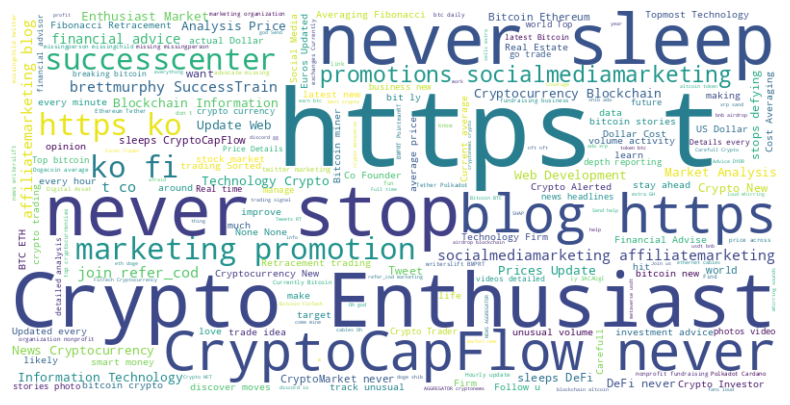

In [ ]:
# Concatenate all user bios into a single string
all_bios = ' '.join(df["userBio"].astype(str))

# Create a WordCloud object
wordcloud_bio = WordCloud(width=800, height=400, background_color='white').generate(all_bios)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bio, interpolation='bilinear')
plt.axis('off')
plt.show()

### **Tweet's body**

To gain a comprehensive understanding of the distribution of words within the "body" column, we have created a word cloud visualization. This visualization allows us to observe the occurrence and frequency of words in the text data, providing a global representation of the overall composition of the "body" column. By examining the word cloud, we can obtain valuable insights into the prominent words and their relative importance in the dataset.

The analysis of the word cloud reveals a discernible pattern suggesting that tweets containing the word "gift" are often associated with bot activity. This observation can serve as a potential method for identifying and distinguishing bot-generated tweets within the dataset. By leveraging this information, we can develop mechanisms to differentiate between genuine user-generated content and tweets originating from automated bot accounts.

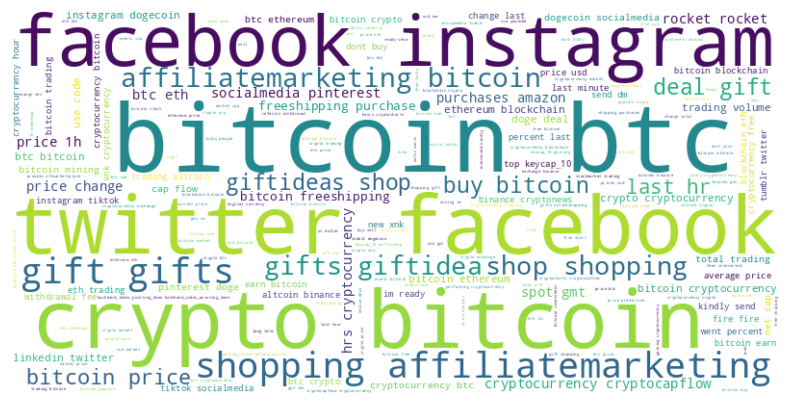

In [ ]:
# Concatenate all tweets bodies into a single string
all_bodies = ' '.join(df["cleaned_body"].astype(str))

# Create a WordCloud object
wordcloud_body = WordCloud(width=800, height=400, background_color='white').generate(all_bodies)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_body, interpolation='bilinear')
plt.axis('off')
plt.show()

## ***Eliminate tweets originating from bots***

To begin, it is necessary to remove tweets originating from bots, from the datasets.

We have successfully eliminated a total of 52k tweets by excluding those that contained specific terms such as "gift.

In [ ]:
# Create an empty list to store the indices of rows to be removed
rows_to_remove = []

# Iterate over the DataFrame rows
for index, row in tqdm(df.iterrows()):
    if ('gift' in row['cleaned_body']) or ('giftideas' in row['cleaned_body']) or ('gifts' in row['cleaned_body']) or ('giftidea' in row['cleaned_body']) or ('giveaway' in row['cleaned_body'])  or ("airdrop" in row['cleaned_body']) or ("cashback" in row['cleaned_body']):
        rows_to_remove.append(index)

734074it [01:17, 9426.79it/s]


In [ ]:
# create a dataset with only the rows of the tweets from bots to show the wordcloud
df_bots = df.iloc[rows_to_remove].copy()
df_bots.reset_index(drop=True, inplace=True)
df_bots.head()

,id,user,inreplyto,link,body,date,postedtime,retweetcount,favoritescount,generator,...,userNumTweets,userVerified,userBio,country,countrycode,locality,region,subregion,locationname,cleaned_body
0,-1735632200,-1642658858,None,http://twitter.com/dedramaxx1/statuses/1001165...,Bitcoin Black 3600 AirDrop $36 Value https://t...,2018-05-28,2018-05-28T18:18:05.000Z,0,0,Twitter Web Client,...,13662,False,"Entreprenuer, Cryptocurrency Expert, Gospel Mu...",United States,US,Chesapeake,Virginia,City of Chesapeake,"Chesapeake, Virginia, United States",bitcoin black 3600 airdrop 36 value via youtube
1,1409523800,-1651002710,None,http://twitter.com/CoinSignalBot/statuses/1003...,5 min #RSI Signals:\n\n$BTC - $SYNX: 2.09\n$BT...,2018-06-03,2018-06-03T21:05:00.000Z,0,0,CoinSignalBot_,...,108913,False,Scans RSI's of all coins and provides signals ...,United States,US,Seattle,Washington,King County,"Seattle, Washington, United States",5 min rsi signals btc synx 209 btc flo 438 btc...
2,-106006800,-1651002710,None,http://twitter.com/CoinSignalBot/statuses/1004...,1 hour #RSI Signals:\n\n$BTC - $AGI: 22.42\n$B...,2018-06-06,2018-06-06T16:50:32.000Z,0,0,CoinSignalBot_,...,110259,False,Scans RSI's of all coins and provides signals ...,United States,US,Seattle,Washington,King County,"Seattle, Washington, United States",1 hour rsi signals btc agi 2242 btc gam 2315 b...
3,-996048400,-1651002710,None,http://twitter.com/CoinSignalBot/statuses/1005...,15 min #RSI Signals:\n\n$BTC - $TKS: 0.47\n$BT...,2018-06-08,2018-06-08T12:00:10.000Z,0,0,CoinSignalBot_,...,111113,False,Scans RSI's of all coins and provides signals ...,United States,US,Seattle,Washington,King County,"Seattle, Washington, United States",15 min rsi signals btc tks 047 btc lgd 106 btc...
4,-1354296800,-75510215,None,http://twitter.com/Brian0602Shelto/statuses/10...,Kokos Token Free #Airdrop: Get more than 500$ ...,2018-06-18,2018-06-18T09:03:50.000Z,0,0,Twitter Web Client,...,42,False,Founded in 2010 by Kevin (http://instagram.com...,United States,US,None,None,None,United States,kokos token free airdrop get 500 kok tokens io...


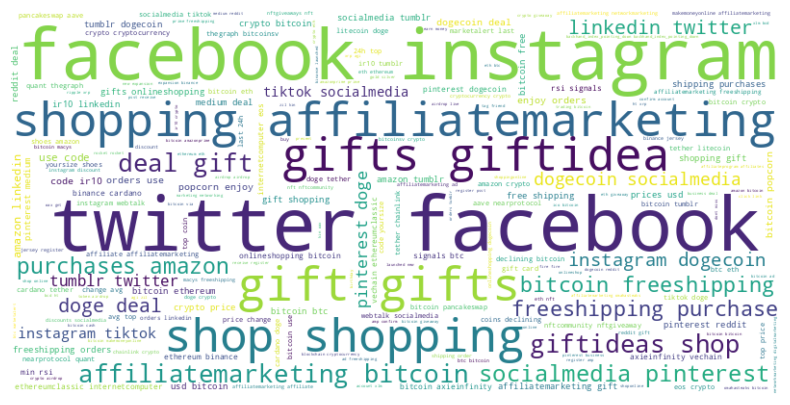

In [ ]:
# Concatenate all tweets bodies into a single string
all_bodies_bots = ' '.join(df_bots["cleaned_body"].astype(str))

# Create a WordCloud object
wordcloud_body_bots = WordCloud(width=800, height=400, background_color='white').generate(all_bodies_bots)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_body_bots, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Remove the rows from the DataFrame, clean the dataset from bots
df = df.drop(rows_to_remove)

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

# Check the updated DataFrame
print("The total number of tweets in the dataset is now: ",df.shape[0])

The total number of tweets in the dataset is now:  682190


Let us now examine the word cloud representation of the 'body' column.

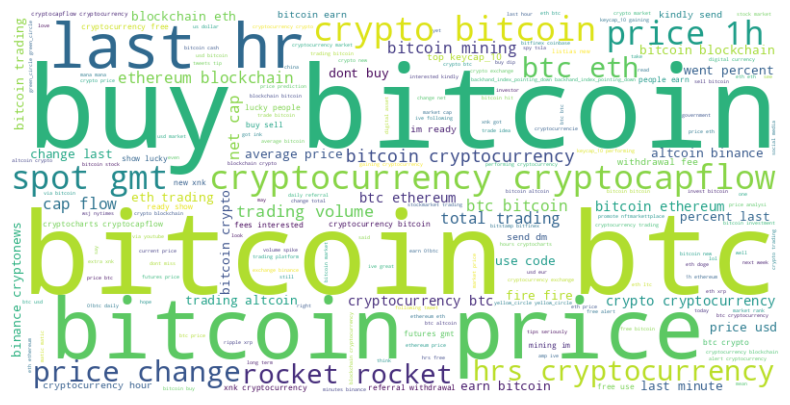

In [ ]:
# Concatenate all tweets bodies into a single string
all_bodies = ' '.join(df["cleaned_body"].astype(str))

# Create a WordCloud object
wordcloud_body = WordCloud(width=800, height=400, background_color='white').generate(all_bodies)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_body, interpolation='bilinear')
plt.axis('off')
plt.show()

# ***BITCOIN PRICE DATASET***

We took the data of Bitcoin USD (BTC-USD) Historical Prices from [Yahoo! Finance](https://finance.yahoo.com/quote/BTC-USD/history/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAJaIMWPrP9oUslbVvmzR6VK46wFe4Rp9aM8iNpp6BPin9eRSrBzSfr5w3ogZGFTn-Lu8i72L3Q48uHwjAZZLxg0eOy6XVYhv-yi92UPRJHMrE9JAKQ9zCgdcA5TuNv9jvzr8D6tvjkiaG4OnxdDbVpJ0heInEtqTlfCR4a8l9KT9). We considered the time interval from January 1 2018 to January 1 2023. so as to encompass the same time period as the collected tweets

In [ ]:
# btc_price = pd.read_csv("C:\\Users\\Alessandro\\Downloads\\BTC-USD.csv")
btc_price = pd.read_csv("/content/drive/MyDrive/BTC-USD.csv")
btc_price.Date = pd.to_datetime(btc_price.Date)
final_df = btc_price

In [ ]:
btc_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072


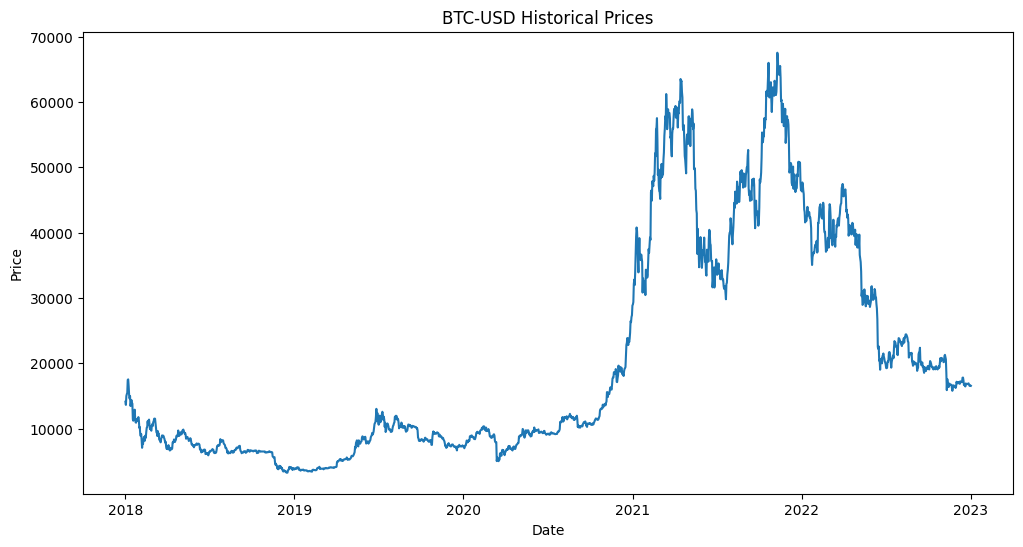

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(btc_price['Date'], btc_price['Open'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC-USD Historical Prices')
plt.show()

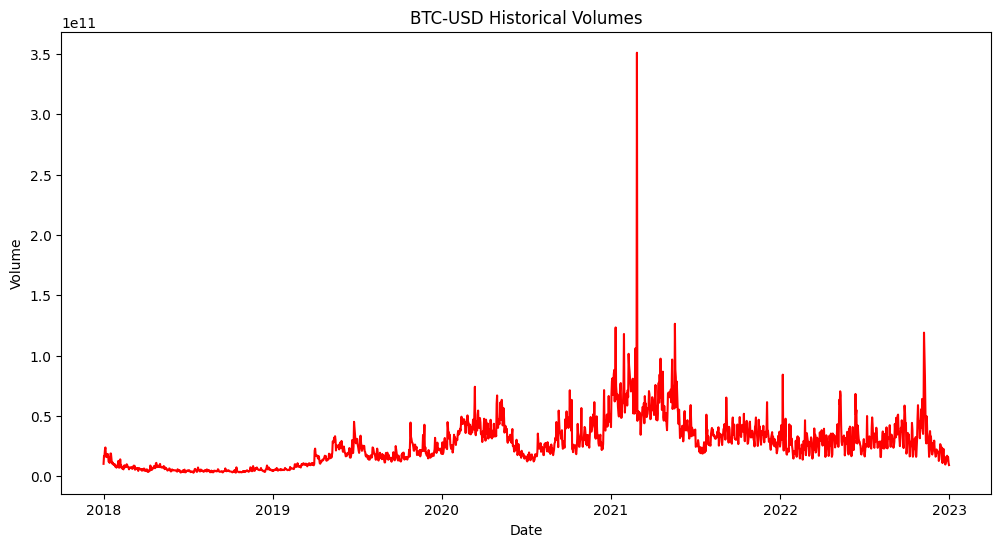

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(btc_price['Date'], btc_price['Volume'], color= "red")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('BTC-USD Historical Volumes')
plt.show()

Let's verify through the Bitcoin price dataset when the maximum and minimum Bitcoin prices were recorded.

According to the dataset, the historical maximum Bitcoin price between 2018-2023 was recorded on November 9, 2021. On the other hand, the minimum Bitcoin price was registered on December 16, 2018.

In [ ]:
max_open = btc_price['Open'].max()
date_of_max_open = btc_price.loc[btc_price['Open'] == max_open, 'Date'].values[0]
print("Maximum Bitcoin price:", max_open)
print("Date of Maximum Bitcoin Price:", date_of_max_open)


Maximum Bitcoin price: 67549.734375
Date of Maximum Bitcoin Price: 2021-11-09T00:00:00.000000000


In [ ]:
min_open = btc_price['Open'].min()
date_of_min_open = btc_price.loc[btc_price['Open'] == min_open, 'Date'].values[0]

print("Minimum Bitcoin price:", min_open)
print("Date of Minimum Bitcoin Price:", date_of_min_open)


Minimum Bitcoin price: 3236.274658
Date of Minimum Bitcoin Price: 2018-12-16T00:00:00.000000000


In [ ]:
btc_price = btc_price[btc_price['Date'] != '2023-01-01']

in the end, we also normalize the price of bitcoins in the [0,100] scale:

In [ ]:
normalized_btc = btc_price['Open']

scaler = MinMaxScaler()

normalized_btc = scaler.fit_transform(normalized_btc.values.reshape(-1, 1))
normalized_btc = pd.Series(normalized_btc.flatten())*100

# **Leading Indicators**

In order to show the correlation between the indices we are going to create and Bitcoin price, we have imported a dataset that will allow us to analyze and determine the extent of correlation between our indices and the price of Bitcoin.

## ***1. Sentiment Analysis of the tweets with DeBERTa distinguishing the sentiment of two different set of users***

### ***Differentiating professional and non professional users***

First of all, we differentiate the different users by analyzing their user bio and checking if it contains information that matches keywords such as "professor," "researcher," "expert," etc. Additionally, we consider all verified users as professionals because this dataset collects tweets about Bitcoin, and we assume that verified users discussing Bitcoin are professionals. Our assumption is reinforced by the word cloud analysis of the user bio for verified users.



682190it [01:03, 10796.36it/s]


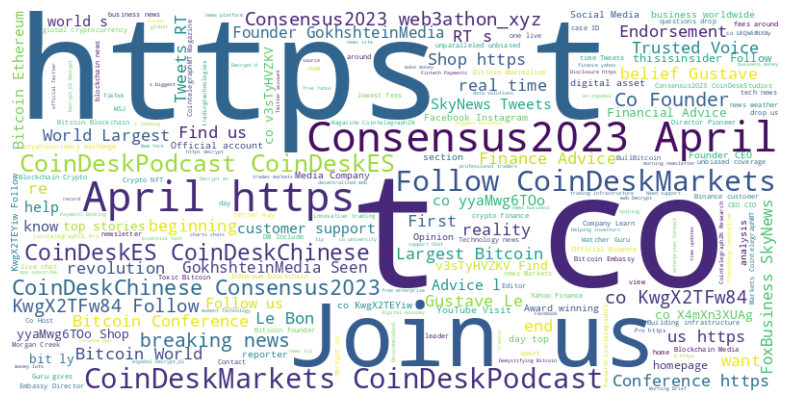

In [ ]:
all_bios_verified_list = []
for index, row in tqdm(df.iterrows()):
  if row["userVerified"] == True:
    if row["userBio"] != None:
      all_bios_verified_list.append(row["userBio"])
all_bios_verified = ' '.join(bio for bio in all_bios_verified_list)
# Create a WordCloud object
wordcloud_bio_verified = WordCloud(width=800, height=400, background_color='white').generate(all_bios_verified)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_bio_verified, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# define the rows that correspond to professionals and the ones that correspond to not professional
professional_rows = list()
for i in tqdm(range(len(df["userBio"]))):
  bio = df["userBio"][i]
  verified = df["userVerified"][i]
  if bio is not None:
    bio = preprocess(bio)
    if ("researcher" in bio) or ("journalist" in bio) or ("professors" in bio) or ("expert" in bio) or ("entrepreneur" in bio) or ("director " in bio) or ("economist" in bio) or (verified==True):
      professional_rows.append(i)

100%|██████████| 682190/682190 [05:51<00:00, 1939.43it/s]


In [ ]:
print("We have identified", len(professional_rows), "professional users")

We have identified 44552 professional users


In [ ]:
# create a new column "is_professional" that takes value 0 if user is not a professional, or value 1 if user is a professional
df["is_professional"] = 0
# impose values 1 if row of df inside the list professional_rows
df.loc[df.index.isin(professional_rows), "is_professional"] = 1

The distribution plot reveals that the majority of users are identified as non-professional.

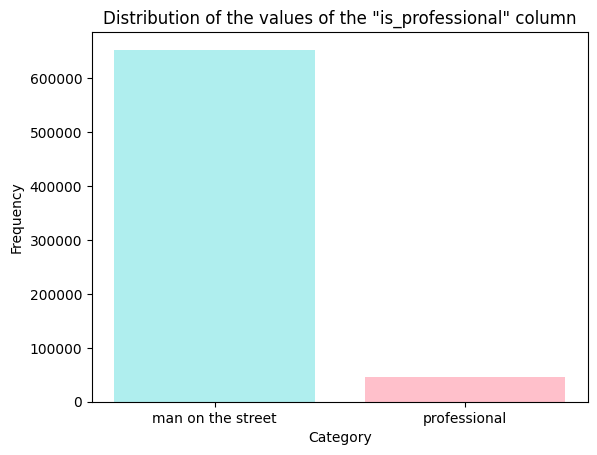

In [ ]:
# plot the distribution of this new column
value_counts = df["is_professional"].value_counts()

colors = ["paleturquoise", "pink"]
plt.bar(['man on the street', 'professional'], value_counts.values, color=colors)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Distribution of the values ​​of the "is_professional" column')
plt.show()

To perform sentiment analysis, we decided to utilize transformers. Specifically, we employed the Hugging Face pipeline for zero-shot classification using the DeBERTa model.

Since performing zero-shot classification with transformers requires a significant amount of computational time, we applied it to a subset of the original dataset to reduce the number of tweets to process.

In [ ]:
classifier_pipeline = pipeline("zero-shot-classification", model = "cross-encoder/nli-deberta-base")

### **1.1 Sentiment in the period of the maximum bitcoin price**

We thought it would be interesting to evaluate the sentiment of tweets in the three days surrounding 9th of November 2021, which is the day when the highest Bitcoin price was reached. Therefore, we created a dataset from the original one that only contains tweets from November 8th, 9th, and 10th. Then, we assessed the difference in the sentiment between users considered professionals in finance and users who are not professionals in finance.

In [ ]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])
# Create a list of desired dates
max_price_dates = ['2021-11-08', '2021-11-09', '2021-11-10']
# Filter the DataFrame based on the desired dates
df_max_price = df[df['date'].isin(max_price_dates)]
df_max_price = df_max_price.reset_index(drop=True)

In [ ]:
sentiment_candidate = ['positive', 'negative', 'neutral']

df_max_price["transformers_positive_weighted"] = 0
df_max_price["transformers_negative_weighted"] = 0
df_max_price["transformers_neutral_weighted"] = 0
df_max_price["transformers_positive"] = 0
df_max_price["transformers_negative"] = 0
df_max_price["transformers_neutral"] = 0

for index, row in tqdm(df_max_price.iterrows()):
  result = classifier_pipeline(row["cleaned_body"], sentiment_candidate)
  for sentiment in range(len(result["labels"])):
    score = result["scores"][sentiment]
    if result["labels"][sentiment] == "positive":
      df_max_price.at[index, 'transformers_positive_weighted'] = (score)*(int(row["favoritescount"])+1) *((int(row["retweetcount"])+1))
      df_max_price.at[index, 'transformers_positive'] = score
    elif result["labels"][sentiment] == "negative":
      df_max_price.at[index, 'transformers_negative_weighted'] = (score)*(int(row["favoritescount"])+1) *((int(row["retweetcount"])+1))
      df_max_price.at[index, 'transformers_negative'] = score
    elif result["labels"][sentiment] == "neutral":
      df_max_price.at[index, 'transformers_neutral_weighted'] = (score)*(int(row["favoritescount"])+1) *((int(row["retweetcount"])+1))
      df_max_price.at[index, 'transformers_neutral'] = score

2546it [29:41,  1.43it/s]


From the results of the sentiment analysis conducted with DeBERTa it can be observed that the sentiment of professional users in the historical period in which the price of Bitcoin reached its positive peak is mostly positive, while the sentiment of non-professionals can be considered sufficiently positive.



In [ ]:
positive_count_pro, negative_count_pro, neutral_count_pro = 0, 0, 0
positive_count_man, negative_count_man, neutral_count_man = 0, 0, 0
for index, row in tqdm(df_max_price.iterrows()):
  max_index = np.argmax([row["transformers_positive_weighted"], row["transformers_negative_weighted"], row["transformers_neutral_weighted"]])
  if row['is_professional'] == 1:
    if max_index == 0:
      positive_count_pro += 1
    elif max_index == 1:
      negative_count_pro += 1
    elif max_index == 2:
      neutral_count_pro += 1
  elif row['is_professional'] == 0:
    if max_index == 0:
      positive_count_man += 1
    elif max_index == 1:
      negative_count_man += 1
    elif max_index == 2:
      neutral_count_man += 1
len_pro = df_max_price[df_max_price['is_professional'] == 1].shape[0]
len_man = df_max_price[df_max_price['is_professional'] == 0].shape[0]
neutral_perc_pro = neutral_count_pro / len_pro
negative_perc_pro = negative_count_pro /len_pro
positive_perc_pro = positive_count_pro /len_pro

neutral_perc_man = neutral_count_man / len_man
negative_perc_man = negative_count_man / len_man
positive_perc_man = positive_count_man / len_man

2546it [00:00, 10668.90it/s]


In [ ]:
print("The overall sentiment of professional users is", round(positive_perc_pro*100,2), "% positive")
print("The overall sentiment of non-professional users is", round(positive_perc_man*100,2), "% positive")

The overall sentiment of professional users is 63.64 % positive
The overall sentiment of non-professional users is 48.65 % positive


***Correlation Evaluation***



The weighted sentiment and the unweighted sentiment are always equal, which indicates that the values of favorite count and retweet count are always 0 for all the tweets in the considered period.

In [ ]:
df_max_price["transformers_positive_weighted"] == df_max_price["transformers_positive"]

0       True
1       True
2       True
3       True
4       True
        ... 
2541    True
2542    True
2543    True
2544    True
2545    True
Length: 2546, dtype: bool

Let's examine the correlation between the sentiment of two different user groups and the price of Bitcoin. Based on what we mentioned earlier, it doesn't matter whether we consider the weighted sentiment or the unweighted sentiment.

It appears that there is a high correlation between the Bitcoin price and the sentiment of professional users.

However, there is a moderate negative correlation between the Bitcoin price and the sentiment of non-professional users.

In [ ]:
df_max_price["date"] = pd.to_datetime(df_max_price["date"])
df_max_price_pro = df_max_price[df_max_price['is_professional'] == 1].reset_index()

# index with weighted score
index_transformers_max_pro_weighted = df_max_price_pro.groupby(df_max_price_pro["date"].dt.date)["transformers_positive_weighted", "transformers_negative_weighted", "transformers_neutral_weighted"].mean().reset_index()
index_transformers_max_pro_weighted["average_sentiment"] = ((index_transformers_max_pro_weighted["transformers_positive_weighted"]) - (index_transformers_max_pro_weighted["transformers_negative_weighted"]) - (index_transformers_max_pro_weighted["transformers_neutral_weighted"])) / ((index_transformers_max_pro_weighted["transformers_positive_weighted"]) + (index_transformers_max_pro_weighted["transformers_negative_weighted"]) + (index_transformers_max_pro_weighted["transformers_neutral_weighted"]))

In [ ]:
correlation_pro_weighted = index_transformers_max_pro_weighted["average_sentiment"].corr(btc_price["Open"])
print("The correlation between the bitcoin price and the professional users sentiment computed with weighted scores is: ", correlation_pro_weighted)

The correlation between the bitcoin price and the professional users sentiment computed with weighted scores is:  0.6796151289359456


In [ ]:
df_max_price_man = df_max_price[df_max_price['is_professional'] == 0].reset_index()

# index with weighted score
index_transformers_max_man_weighted = df_max_price_man.groupby(df_max_price_man["date"].dt.date)["transformers_positive_weighted", "transformers_negative_weighted", "transformers_neutral_weighted"].mean().reset_index()
index_transformers_max_man_weighted["average_sentiment"] = ((index_transformers_max_man_weighted["transformers_positive_weighted"]) - (index_transformers_max_man_weighted["transformers_negative_weighted"]) - (index_transformers_max_man_weighted["transformers_neutral_weighted"])) / ((index_transformers_max_man_weighted["transformers_positive_weighted"]) + (index_transformers_max_man_weighted["transformers_negative_weighted"]) + (index_transformers_max_man_weighted["transformers_neutral_weighted"]))

In [ ]:
correlation_man_weighted = index_transformers_max_man_weighted["average_sentiment"].corr(btc_price["Open"])
print("The correlation between the bitcoin price and the non-professional users sentiment computed with weighted scores is: ", correlation_man_weighted)

The correlation between the bitcoin price and the non-professional users sentiment computed with weighted scores is:  -0.4959476146162864


In [ ]:
final_df["Date"] = pd.to_datetime(final_df["Date"])

dates = final_df['Date'].isin(max_price_dates)
indices = final_df[dates].index

final_df['index_transformers_max_man_weighted'] = None
final_df['index_transformers_max_pro_weighted'] = None

for index, row in tqdm(final_df.iterrows()):
  if index == indices[0]:
    final_df.at[index, 'index_transformers_max_man_weighted'] = index_transformers_max_man_weighted["average_sentiment"][0]
    final_df.at[index, 'index_transformers_max_pro_weighted'] = index_transformers_max_pro_weighted["average_sentiment"][0]
  elif index == indices[1]:
    final_df.at[index, 'index_transformers_max_man_weighted'] = index_transformers_max_man_weighted["average_sentiment"][1]
    final_df.at[index, 'index_transformers_max_pro_weighted'] = index_transformers_max_pro_weighted["average_sentiment"][1]
  elif index == indices[2]:
    final_df.at[index, 'index_transformers_max_man_weighted'] = index_transformers_max_man_weighted["average_sentiment"][2]
    final_df.at[index, 'index_transformers_max_pro_weighted'] = index_transformers_max_pro_weighted["average_sentiment"][2]

1827it [00:00, 15148.24it/s]


### **1.2 Sentiment in the period of the minimum bitcoin price**

We thought it would be interesting to evaluate the sentiment of tweets also in the days surrounding 16th of December 2018, which is the day when the lowest Bitcoin price was reached. Therefore, we created a dataset from the original one that only contains tweets from December 15th to December 17th. Then, we assessed the difference in the sentiment between users considered professionals in finance and users who are not professionals in finance.

In [ ]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])
# Create a list of desired dates
min_price_dates = ['2018-12-15', '2018-12-16', '2018-12-17']
# Filter the DataFrame based on the desired dates
df_min_price = df[df['date'].isin(min_price_dates)]
df_min_price = df_min_price.reset_index(drop=True)

In [ ]:
sentiment_candidate = ['positive', 'negative', 'neutral']
df_min_price["transformers_positive_weighted"] = 0
df_min_price["transformers_negative_weighted"] = 0
df_min_price["transformers_neutral_weighted"] = 0
df_min_price["transformers_positive"] = 0
df_min_price["transformers_negative"] = 0
df_min_price["transformers_neutral"] = 0
for index, row in tqdm(df_min_price.iterrows()):
  result = classifier_pipeline(row["cleaned_body"], sentiment_candidate)
  for sentiment in range(len(result["labels"])):
    score = result["scores"][sentiment]
    if result["labels"][sentiment] == "positive":
      df_min_price.at[index, 'transformers_positive_weighted'] = (score)*(int(row["favoritescount"])+1) *((int(row["retweetcount"])+1))
      df_min_price.at[index, 'transformers_positive'] = score
    elif result["labels"][sentiment] == "negative":
      df_min_price.at[index, 'transformers_negative_weighted'] = (score)*(int(row["favoritescount"])+1) *((int(row["retweetcount"])+1))
      df_min_price.at[index, 'transformers_negative'] = score
    elif result["labels"][sentiment] == "neutral":
      df_min_price.at[index, 'transformers_neutral_weighted'] = (score)*(int(row["favoritescount"])+1) *((int(row["retweetcount"])+1))
      df_min_price.at[index, 'transformers_neutral'] = score

401it [04:07,  1.62it/s]


In [ ]:
positive_count_pro, negative_count_pro, neutral_count_pro = 0, 0, 0
positive_count_man, negative_count_man, neutral_count_man = 0, 0, 0
for index, row in tqdm(df_min_price.iterrows()):
  max_index = np.argmax([row["transformers_positive_weighted"], row["transformers_negative_weighted"], row["transformers_neutral_weighted"]])
  if row['is_professional'] == 1:
    if max_index == 0:
      positive_count_pro += 1
    elif max_index == 1:
      negative_count_pro += 1
    elif max_index == 2:
      neutral_count_pro += 1
  elif row['is_professional'] == 0:
    if max_index == 0:
      positive_count_man += 1
    elif max_index == 1:
      negative_count_man += 1
    elif max_index == 2:
      neutral_count_man += 1
len_pro = df_min_price[df_min_price['is_professional'] == 1].shape[0]
len_man = df_min_price[df_min_price['is_professional'] == 0].shape[0]
neutral_perc_pro = neutral_count_pro / len_pro
negative_perc_pro = negative_count_pro /len_pro
positive_perc_pro = positive_count_pro /len_pro

neutral_perc_man = neutral_count_man / len_man
negative_perc_man = negative_count_man / len_man
positive_perc_man = positive_count_man / len_man

401it [00:00, 9705.06it/s]


Based on the results of the sentiment analysis conducted with DeBERTa, it can be observed that the sentiment of both professionals and non-professionals during the historical period when the Bitcoin price reached its lowest peak can be considered relatively neutral. The sentiment of professional users is slightly more negative compared to that of non-professional users. This nearly neutral sentiment can be attributed to the fact that only 401 tweets were collected during those days of the lowest peak. This indicates that the topic of Bitcoin price was not trending significantly, and therefore, users expressed less of their sentiment on Twitter regarding this particular topic.

In [ ]:
print("The overall sentiment of professional users is", round(negative_perc_pro*100,2), "% negative")
print("The overall sentiment of non-professional users is", round(negative_perc_man*100,2), "% negative")

The overall sentiment of professional users is 51.22 % negative
The overall sentiment of non-professional users is 39.72 % negative


***Correlation Evaluation***




The weighted sentiment and the unweighted sentiment are always equal, which indicates that the values of favorite count and retweet count are always 0 for all the tweets in the considered period.

In [ ]:
df_min_price["transformers_negative_weighted"] == df_min_price["transformers_negative"]

0      True
1      True
2      True
3      True
4      True
       ... 
396    True
397    True
398    True
399    True
400    True
Length: 401, dtype: bool

In [ ]:
df_min_price["date"] = pd.to_datetime(df_min_price["date"])
df_min_price_pro = df_min_price[df_min_price['is_professional'] == 1].reset_index()

# index with weighted score
index_transformers_min_pro_weighted = df_min_price_pro.groupby(df_min_price_pro["date"].dt.date)["transformers_positive_weighted", "transformers_negative_weighted", "transformers_neutral_weighted"].mean().reset_index()
index_transformers_min_pro_weighted["average_sentiment"] =((index_transformers_min_pro_weighted["transformers_positive_weighted"]) - (index_transformers_min_pro_weighted["transformers_negative_weighted"]) - (index_transformers_min_pro_weighted["transformers_neutral_weighted"])) / ((index_transformers_min_pro_weighted["transformers_positive_weighted"]) + (index_transformers_min_pro_weighted["transformers_negative_weighted"]) + (index_transformers_min_pro_weighted["transformers_neutral_weighted"]))

Let's examine the correlation between the sentiment of two different user groups and the price of Bitcoin.

It appears that there is a high positive correlation between the Bitcoin price and the sentiment of professional users.

However, there is none correlation between the Bitcoin price and the sentiment of non-professional users.

In [ ]:
correlation_pro_weighted = index_transformers_min_pro_weighted["average_sentiment"].corr(btc_price["Open"])
print("The correlation between the bitcoin price and the professional users sentiment computed with wieghted scores is: ", correlation_pro_weighted)

The correlation between the bitcoin price and the professional users sentiment computed with wieghted scores is:  -0.9710444984882826


In [ ]:
df_min_price_man = df_min_price[df_min_price['is_professional'] == 0].reset_index()

# index with weighted score
index_transformers_min_man_weighted = df_min_price_man.groupby(df_min_price_man["date"].dt.date)["transformers_positive_weighted", "transformers_negative_weighted", "transformers_neutral_weighted"].mean().reset_index()
index_transformers_min_man_weighted["average_sentiment"] = ((index_transformers_min_man_weighted["transformers_positive_weighted"]) - (index_transformers_min_man_weighted["transformers_negative_weighted"]) - (index_transformers_min_man_weighted["transformers_neutral_weighted"])) / ((index_transformers_min_man_weighted["transformers_positive_weighted"]) + (index_transformers_min_man_weighted["transformers_negative_weighted"]) + (index_transformers_min_man_weighted["transformers_neutral_weighted"]))


In [ ]:
correlation_man_weighted = index_transformers_min_man_weighted["average_sentiment"].corr(btc_price["Open"])
print("The correlation between the bitcoin price and the non-professional users sentiment computed with weighted scores is: ", correlation_man_weighted)

The correlation between the bitcoin price and the non-professional users sentiment computed with weighted scores is:  0.24195641444587582


In [ ]:
dates = final_df['Date'].isin(min_price_dates)
indices = final_df[dates].index

final_df['index_transformers_min_man_weighted'] = None
final_df['index_transformers_min_pro_weighted'] = None

for index, row in tqdm(final_df.iterrows()):
  if index == indices[0]:
    final_df.at[index, 'index_transformers_min_man_weighted'] = index_transformers_min_man_weighted["average_sentiment"][0]
    final_df.at[index, 'index_transformers_min_pro_weighted'] = index_transformers_min_pro_weighted["average_sentiment"][0]
  elif index == indices[1]:
    final_df.at[index, 'index_transformers_min_man_weighted'] = index_transformers_min_man_weighted["average_sentiment"][1]
    final_df.at[index, 'index_transformers_min_pro_weighted'] = index_transformers_min_pro_weighted["average_sentiment"][1]
  elif index == indices[2]:
    final_df.at[index, 'index_transformers_min_man_weighted'] = index_transformers_min_man_weighted["average_sentiment"][2]
    final_df.at[index, 'index_transformers_min_pro_weighted'] = index_transformers_min_pro_weighted["average_sentiment"][2]

1827it [00:00, 15485.08it/s]


## ***2. Sentiment index with Word2vec***

We used the pretrained Google News word2vec model downloaded from this link: https://github.com/mmihaltz/word2vec-GoogleNews-vectors.

We create a list of positive words in the financial domain that indicate positive sentiment, as well as a list of negative words that indicate negative sentiment. We then apply the pretrained Word2Vec model to the words in the list.

In [ ]:
# Load pretrained word2vec
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
positive_words = ["bullish","profitable","growth", "success","prosperity","opportunity","wealth","advancement","breakthrough","secure","promising","exciting","enthusiastic","good","great"]
negative_words = ["bearish","loss","volatility","risky","decline","failure","uncertainty","downfall","crisis","collapse","downturn","disappointing","unstable","bad", "awful"]

In [ ]:
positive_words_vectors = [model[word] for word in positive_words]
negative_words_vectors = [model[word] for word in negative_words]

Now, let's process the tweets in the dataset.

For each word in the body of the tweet, we will check if it is present in the list of positive words. If it is, we will calculate the cosine similarity between the vector representation of the word obtained from the pretrained Word2Vec model and the vectors of the positive words in the positive word list.

At this point, we add the cosine similarity to "sentiment_score" index.

We repeat this process in the same manner to check if the word is in the list of negative words. The only difference is that, in this case, the cosine similarity is subtracted from the "sentiment_score" index.

In [ ]:
sentiment_word2vec = []
# we need these vetors to compute the cosine similarity later
positive_vectors_mean = np.mean(positive_words_vectors, axis=0)
negative_vectors_mean = np.mean(negative_words_vectors, axis=0)
for index, row in tqdm(df.iterrows()):
  body = word_tokenize(row["cleaned_body"])
  sentiment_score = 0
  for word in body:
    if word in model.key_to_index:
      word_vector = model[word]
      if word in positive_words:
        similarity = np.dot(word_vector, positive_vectors_mean) / (np.linalg.norm(word_vector) * np.linalg.norm(positive_vectors_mean))
        sentiment_score += similarity
      elif word in negative_words:
        similarity = np.dot(word_vector, negative_vectors_mean) / (np.linalg.norm(word_vector) * np.linalg.norm(negative_vectors_mean))
        sentiment_score -= similarity
  sentiment_word2vec.append(sentiment_score)

# add a new column with the sentiment score from word2vec
df['Sentiment_word2vec'] = sentiment_word2vec

682190it [03:52, 2930.27it/s]


In [ ]:
print("In general, the sentiment of all the tweets is neutral",df['Sentiment_word2vec'].mean())

In general, the sentiment of all the tweets is neutral 0.03377109736374087


Let's create an index that indicates the average sentiment of tweets for each day. After that, we'll examine the correlation between the index and the daily price of Bitcoin. It is observed that since the sentiment is predominantly neutral, there isn't a strong correlation between the index and the price of Bitcoin.

In [ ]:
df["date"] = pd.to_datetime(df["date"])
index_word2vec = df.groupby(df["date"].dt.date)["Sentiment_word2vec"].mean().reset_index()

In [ ]:
correlation_word2vec = index_word2vec["Sentiment_word2vec"].corr(btc_price["Open"])
print("The correlation between the bitcoin price and the index obtained with word2vec is: ", correlation_word2vec)

The correlation between the bitcoin price and the index obtained with word2vec is:  0.31671766958784336


In [ ]:
final_df = final_df[final_df['Date'] != '2023-01-01']

In [ ]:
final_df['index_word2vec'] = index_word2vec["Sentiment_word2vec"]

<ipython-input-129-ba4390470ee7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['index_word2vec'] = index_word2vec["Sentiment_word2vec"]


In [ ]:
final_df.to_csv('final_df.csv', index=False)

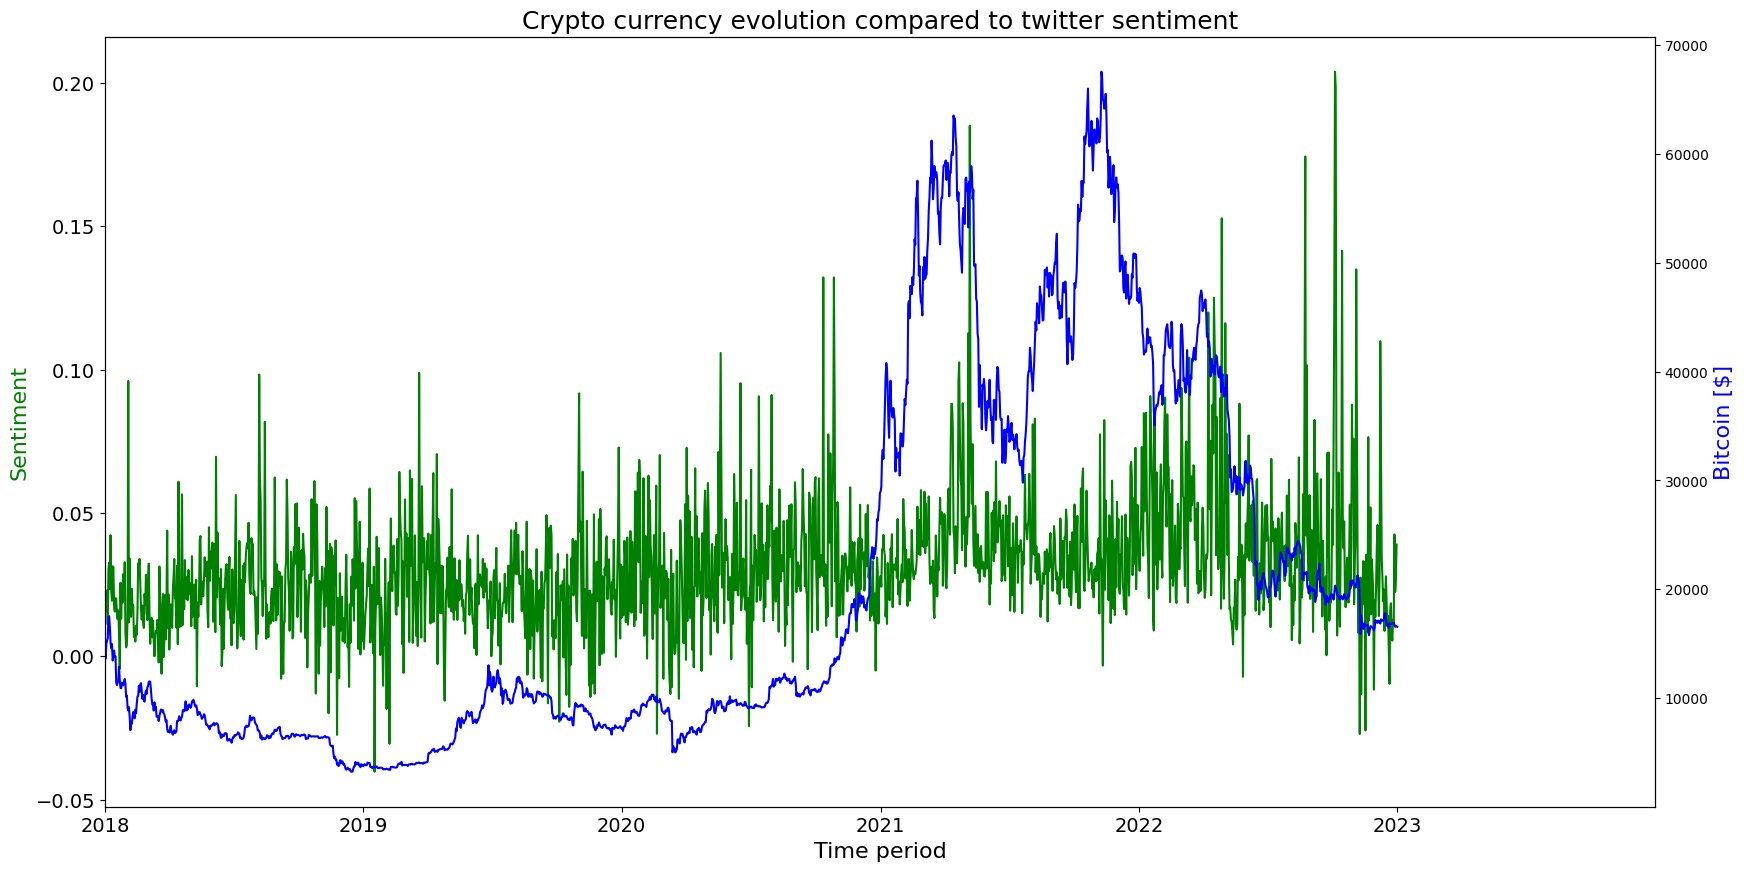

In [ ]:
index_word2vec["date"] = pd.to_datetime(index_word2vec["date"])
filtered_sentiment = index_word2vec[(index_word2vec["date"].dt.year >= 2018) & (index_word2vec["date"].dt.year <= 2023)]
filtered_btc_price = btc_price[(btc_price["Date"].dt.year >= 2018) & (btc_price["Date"].dt.year <= 2023)]

fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(filtered_sentiment["date"], filtered_sentiment["Sentiment_word2vec"], 'g-')
ax2.plot_date(filtered_btc_price["Date"], filtered_btc_price["Open"], 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax1.set_xlabel("Time period", fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
# Set x-axis range from 2018 to 2023
plt.xlim(pd.to_datetime("2018-01-01"), pd.to_datetime("2023-12-31"))
plt.show()

### ***Index Analysis***

We want to perform some analysis on this index. On average, the index reflects a neutral sentiment for the majority of the tweets. This result aligns with our expectations based on the outcomes of other utilized indices.

However, we would like to conduct some analysis on the tweets that resulted in positive sentiment and tweets with negative sentiment.

In [ ]:
# collect the rows of positive and negative tweets in order to create the datasets later
positive_tweets_row = []
negative_tweets_row = []
for index, row in tqdm(df.iterrows()):
  if row["Sentiment_word2vec"] >= 0.5:
    positive_tweets_row.append(index)
  elif row["Sentiment_word2vec"] <= -0.5:
    negative_tweets_row.append(index)

682190it [00:35, 19095.00it/s]


***Positive tweets analysis***

As for the tweets with positive sentiment, there are no interesting findings or results.

In [ ]:
# create a dataset with only the positive tweets
df_positive_word2vec = df.loc[positive_tweets_row]
df_positive_word2vec = df_positive_word2vec.reset_index(drop=True)

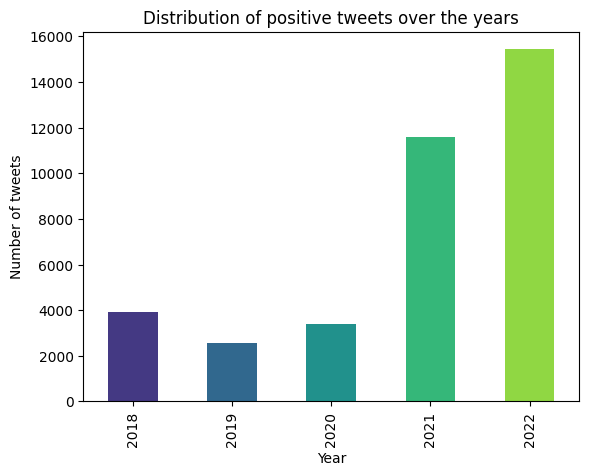

In [ ]:
df_positive_word2vec['date'] = pd.to_datetime(df_positive_word2vec['date'])
years = df_positive_word2vec['date'].dt.strftime('%Y')
years_counts = years.value_counts().sort_index()

num_bars = len(years_counts)
colors = sns.color_palette("viridis", n_colors=num_bars)
years_counts.plot(kind='bar', color=colors)
plt.xlabel('Year')
plt.ylabel('Number of tweets')
plt.title('Distribution of positive tweets over the years')
plt.show()

***Negative tweets analysis***

Regarding the negative tweets, they are distributed between 2018 and 2021 in a manner consistent with the price trend of Bitcoin, as well as the number of tweets collected by the dataset for each year.

However, in 2022, there is a significant peak in the number of negative tweets. Therefore, we have further investigated the distribution of tweets across different months in 2022.

We observed a peak of negative tweets in November 2022. Indeed, November 2022 was a challenging month as it witnessed one of the most significant asset crashes in recent times.

In [ ]:
# create a dataset with only the negative tweets
df_negative_word2vec = df.loc[negative_tweets_row]
df_negative_word2vec = df_negative_word2vec.reset_index(drop=True)

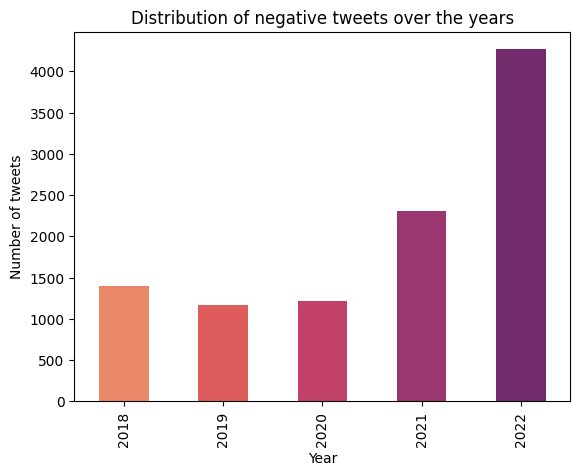

In [ ]:
df_negative_word2vec['date'] = pd.to_datetime(df_negative_word2vec['date'])
years = df_negative_word2vec['date'].dt.strftime('%Y')
years_counts = years.value_counts().sort_index()

num_bars = len(years_counts)
colors = sns.color_palette("flare", n_colors=num_bars)
years_counts.plot(kind='bar', color=colors)
plt.xlabel('Year')
plt.ylabel('Number of tweets')
plt.title('Distribution of negative tweets over the years')
plt.show()

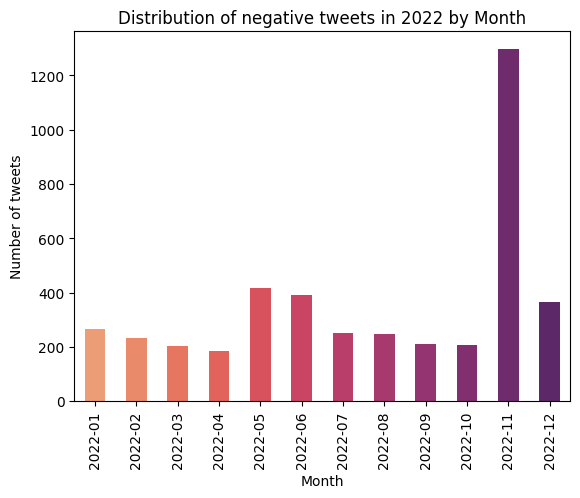

In [ ]:
df_negative_word2vec['date'] = pd.to_datetime(df_negative_word2vec['date'])
df_2022 = df_negative_word2vec[df_negative_word2vec['date'].dt.year == 2022]

# Extract months and compute counts
months = df_2022['date'].dt.strftime('%Y-%m')
months_counts = months.value_counts().sort_index()

num_bars = len(months_counts)
colors = sns.color_palette("flare", n_colors=num_bars)
months_counts.plot(kind='bar', color=colors)
plt.xlabel('Month')
plt.ylabel('Number of tweets')
plt.title('Distribution of negative tweets in 2022 by Month')
plt.show()

As a matter of fact, as observed from the following graph in November 2022, there is a correlation between sentiment and the price of Bitcoin

In [ ]:
index_word2vec_negative = df_negative_word2vec.groupby(df_negative_word2vec["date"].dt.date)["Sentiment_word2vec"].mean().reset_index()

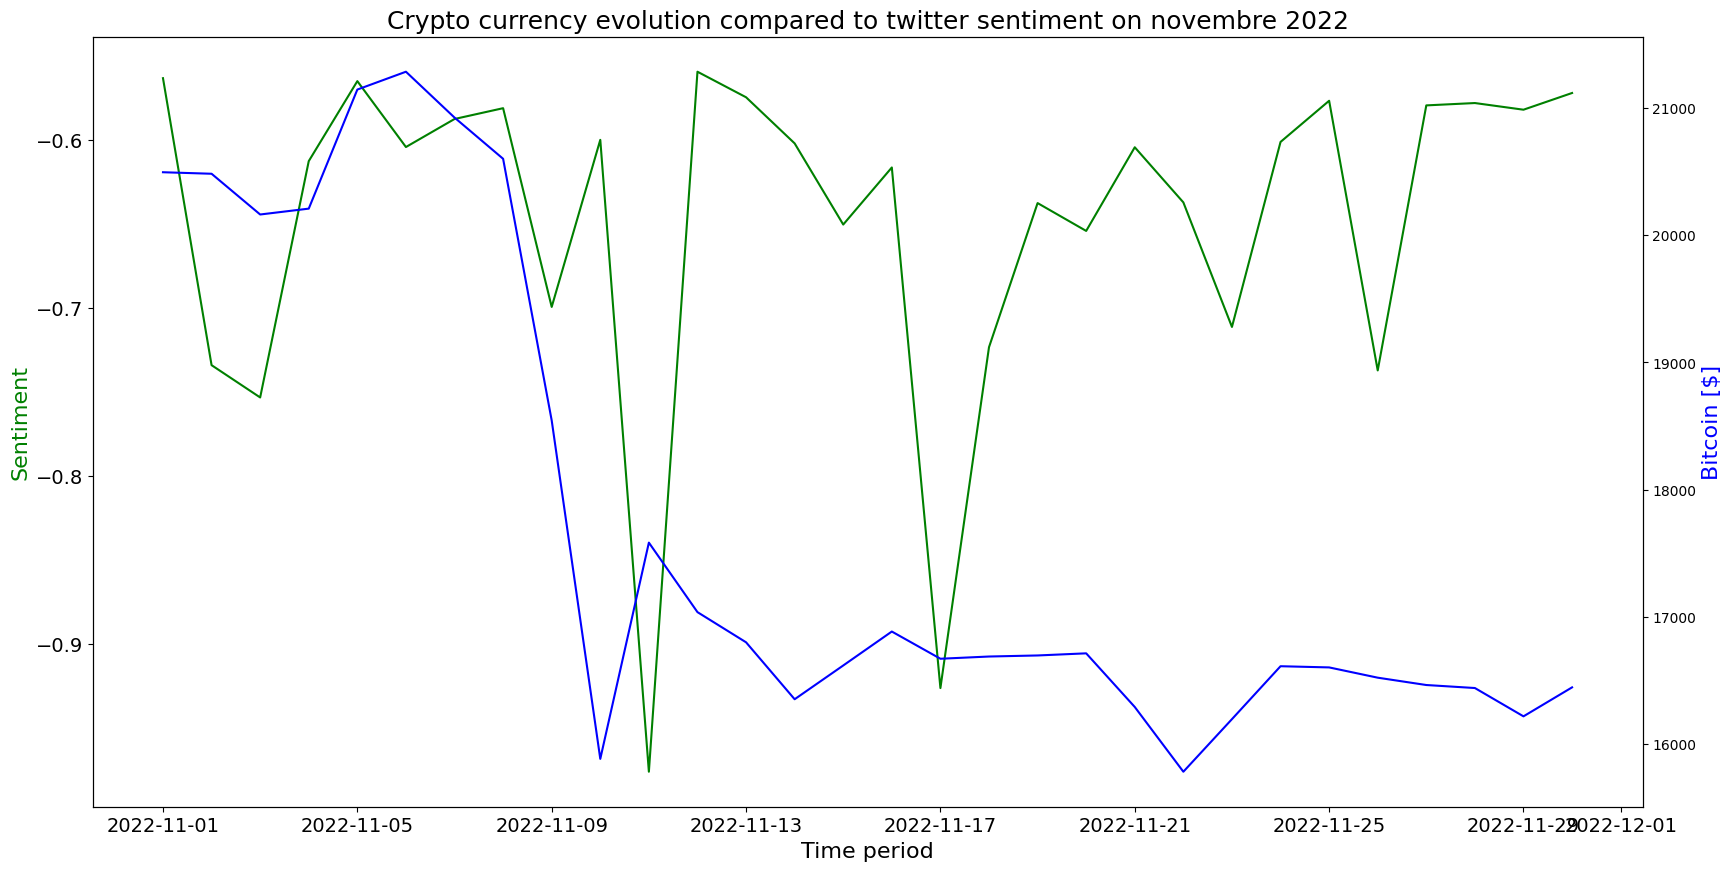

In [ ]:
index_word2vec_negative["date"] = pd.to_datetime(index_word2vec_negative["date"])
filtered_sentiment_negative = index_word2vec_negative[(index_word2vec_negative["date"].dt.year == 2022) & (index_word2vec_negative["date"].dt.month == 11)]
filtered_btc_price = btc_price[(btc_price["Date"].dt.year == 2022) & (btc_price["Date"].dt.month == 11)]

fig, ax1 = plt.subplots(figsize=(20, 10))
ax1.set_title("Crypto currency evolution compared to twitter sentiment on novembre 2022", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(filtered_sentiment_negative["date"], filtered_sentiment_negative["Sentiment_word2vec"], 'g-')
ax2.plot_date(filtered_btc_price["Date"], filtered_btc_price["Open"], 'b-')

ax1.set_ylabel("Sentiment", color='g', fontsize=16)
ax1.set_xlabel("Time period", fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='b', fontsize=16)
plt.show()

## ***3. Sentiment Analysis of the tweets with VADER***

First, we compute the VADER score.

Then, we create a dataset where we collect the VADER scores.

In [ ]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [ ]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(word_tokenize(x)))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(word_tokenize(x)))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(word_tokenize(x)))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(word_tokenize(x)))["compound"])
    return df

In [ ]:
df_vader = compute_vader_scores(df,'body')

The sentiment scores provided by VADER are typically between -1 and +1. A score close to +1 indicates a highly positive sentiment, while a score close to -1 indicates a highly negative sentiment. A score around 0 suggests a neutral sentiment.

Apart from the overall sentiment score, VADER also provides separate scores for positive, negative, and neutral sentiments, as well as a compound score that represents the overall sentiment intensity.

Let's analyze the results of applying VADER sentiment analysis to our dataset.

In [ ]:
df_vader.head()

,id,user,inreplyto,link,body,date,postedtime,retweetcount,favoritescount,generator,...,country,countrycode,locality,region,subregion,locationname,vader_neg,vader_neu,vader_pos,vader_comp
0,-712159200,-1179232094,None,http://twitter.com/hamel1776/statuses/10011537...,south africa investigates 80 million bitcoin s...,2018-05-28,2018-05-28T17:30:28.000Z,0,0,Twitter Web Client,...,United States,US,None,Maine,None,"Maine, United States",0.346,0.654,0.000,-0.5719
1,560828400,-631709376,None,http://twitter.com/CoinLook/statuses/100134212...,asian cryptocurrency trading roundup bitcoin d...,2018-05-29,2018-05-29T05:59:00.000Z,0,0,Buffer,...,United States,US,None,None,None,United States,0.000,0.833,0.167,0.2023
2,-2131331600,-2048482217,None,http://twitter.com/pattern_crypto/statuses/100...,btc volume spike 65 coin print 722500 btcusd b...,2018-05-29,2018-05-29T11:01:19.000Z,0,0,gdax_tweeter,...,United States,US,Manhattan,New York,New York County,"Manhattan, New York, United States",0.000,1.000,0.000,0.0000
3,-331790400,-1814298824,None,http://twitter.com/TheAniKingdom/statuses/1001...,rt ebtcfoundation need support community pleas...,2018-05-29,2018-05-29T15:34:09.000Z,0,0,IFTTT,...,United States,US,None,New York,None,"New York, United States",0.000,0.762,0.238,0.6124
4,-891806600,-311392365,None,http://twitter.com/noashavit/statuses/10014904...,investors bet 4 billion cryptocurrency startup,2018-05-29,2018-05-29T15:48:28.000Z,0,0,IFTTT,...,United States,US,San Francisco,California,San Francisco County,"San Francisco, California, United States",0.000,1.000,0.000,0.0000


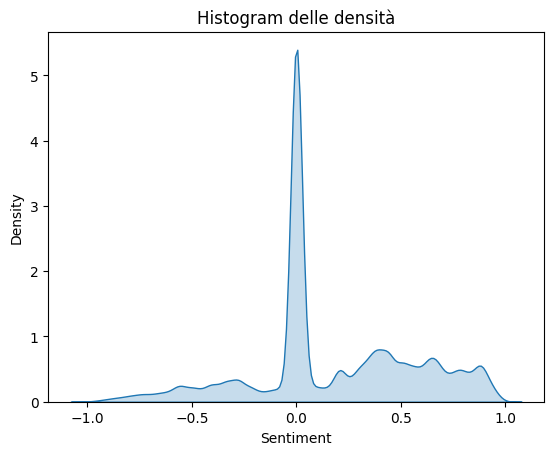

In [ ]:
sns.kdeplot(data=df_vader.vader_comp,  fill=True)

plt.xlabel('Sentiment')
plt.ylabel('Density')
plt.title('Density Histogram')
plt.show()

Let's examine how the sentiment of tweets is distributed across different days since 2018. It is observed that the sentiment, according to the VADER score, remains consistently neutral throughout.

There is no observable change in the sentiment of the tweets that appears to be influenced by the fluctuation in Bitcoin price over the days.

In [ ]:
df_vader['date'] = pd.to_datetime(df_vader['date'])
vader_mean_sentiment = df_vader.groupby(df_vader['date'].dt.date)['vader_comp'].mean()
print(vader_mean_sentiment)

date
2018-01-01    0.157965
2018-01-02    0.172676
2018-01-03    0.174771
2018-01-04    0.090835
2018-01-05    0.144409
                ...   
2022-12-27    0.178675
2022-12-28    0.150439
2022-12-29    0.170485
2022-12-30    0.152412
2022-12-31    0.231112
Name: vader_comp, Length: 1826, dtype: float64


In [ ]:
vader_index = (vader_mean_sentiment + 1) * 50
print(vader_index)

date
2018-01-01    57.898243
2018-01-02    58.633798
2018-01-03    58.738566
2018-01-04    54.541731
2018-01-05    57.220443
                ...    
2022-12-27    58.933737
2022-12-28    57.521939
2022-12-29    58.524244
2022-12-30    57.620619
2022-12-31    61.555615
Name: vader_comp, Length: 1826, dtype: float64


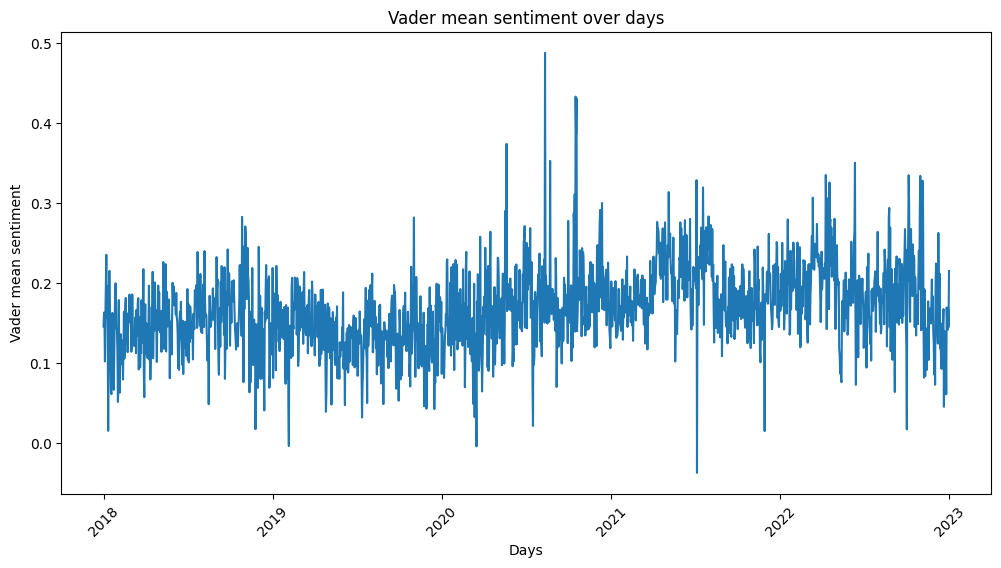

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(vader_mean_sentiment.index, vader_mean_sentiment.values)


plt.xlabel('Days')
plt.ylabel('Vader mean sentiment')
plt.title('Vader mean sentiment over days')
plt.xticks(rotation=45)
plt.show()

In [ ]:
correlation_vader = np.corrcoef(vader_index, btc_price.Open.values)[0, 1]
print("The correlation between the bitcoin price and the Vader index is equal to",round(correlation_vader, 2))

The correlation between the bitcoin price and the Vader index is equal to 0.37


In [ ]:
final_df['vader_index'] = vader_index.values

<ipython-input-143-990a4ff10362>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['vader_index'] = vader_index.values


## ***4. Cryptocurrencies tweet volumes***

Another idea we have to build an indicator is to use the tweets volumes of the day in our sample: We basically counts the number of tweets of each day in our dataset, then we map the value in the [0,100] scale

In [ ]:
df['date'] = pd.to_datetime(df['date'])
tweets_per_day = df.groupby(df['date'].dt.date).count()
normalized_tweets = (tweets_per_day['id'] - tweets_per_day['id'].min()) / (tweets_per_day['id'].max() - tweets_per_day['id'].min()) * 100

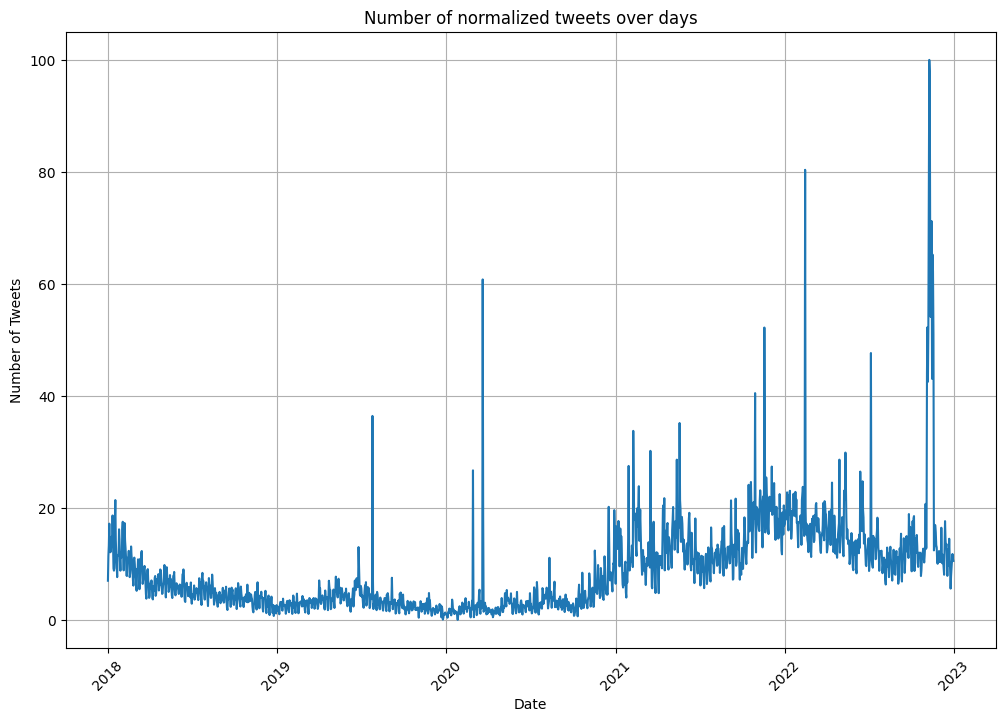

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(normalized_tweets.index, normalized_tweets)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.title('Number of normalized tweets over days')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
if len(btc_price.Open.values) == len(normalized_tweets.values):
  print("The two vectors have the same length")
else:
  print("The two vectors do not have the same length")

The two vectors have the same length


Since the two vectors have the same length we can proceed

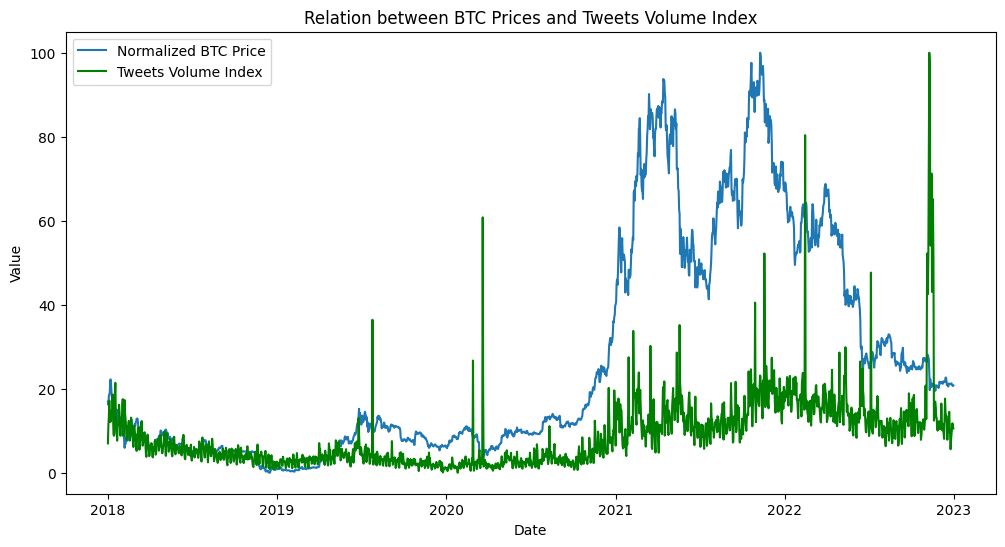

In [ ]:
plt.figure(figsize=(12, 6))

# fisrt plot
plt.plot(btc_price['Date'], normalized_btc)
plt.xlabel('Date')

plt.title('Relation between BTC Prices and Tweets Volume Index')

# second plot
plt.plot(btc_price['Date'], normalized_tweets.values,color="green")
plt.ylabel('Value')

plt.legend(['Normalized BTC Price', 'Tweets Volume Index'])

plt.show()

In [ ]:
correlation = np.corrcoef(normalized_tweets.values, btc_price.Open.values)[0, 1]
print("The correlation between the bitcoin price and the daily volumes of tweets is equal to",round(correlation,2))

The correlation between the bitcoin price and the daily volumes of tweets is equal to 0.55


we can see that there is a moderate correlation between the index on the volume of tweets created.

Since we do not know how our data was sampled, so there may be noise within our dataset, we wanted to try to "adjust" the previous index created through data from google trend.
We downloaded two csv from the site, one about the word "Crypto" and the other is about "Bitcoin" both for the time interval from 2018-01-01 to 2023-01-01. Those data are weekly, so we have one value for each week.

First we created one index that for each week computes a weighted average of the two scores of the google trends csv:

$$ aggregate\_GT\_index_w = 0.6*GT\_Crypto_w + 0.4*GT\_BTC_w
$$

To arrive to the final index we make another average between the previuos normalized_tweets index and the aggregate\_GT\_index_w:


$$ balanced\_volume\_index_i = 0.5*normalized\_tweets_i + 0.5*aggregate\_GT\_index_w
$$

(where *i* is a day of the week *w*)

In [ ]:
crypto_google = pd.read_csv("/content/drive/MyDrive/crypto_google_trend.csv")
BTC_google = pd.read_csv("/content/drive/MyDrive/Bitcoin_google_trend.csv")

In [ ]:
google_trends_index=(0.6*crypto_google[' value'] + 0.4*BTC_google[' value'])

In [ ]:
# since we are dealing with two dataset that have different time frequencies:
max_value_list = math.floor(len(normalized_tweets) / 7) # it finds how many weeks are in the dataset
values = []
current_value = 0

while current_value <= max_value_list*7:
    values.append(current_value)
    current_value += 7

values.append(len(normalized_tweets)) # since the last groups have only 6 days, we add here the last value

In [ ]:
# let's set the weights
weight_number_tweets = 0.5
weight_google_trend = 0.5

In [ ]:
balanced_index=[]
for i in range(0,260+1):

    limit1= values[i]
    limit2=values[i+1]
    # limit1 and limit2 finds how divide in the rigth intervals the normalized_tweets
    a=weight_number_tweets*normalized_tweets[limit1: limit2].values + weight_google_trend*google_trends_index[i]
    balanced_index.append(a.tolist()) # compute the score and save in a list of lists format

balanced_volume_index =  [item for sublist in balanced_index for item in sublist] # unlist the internal lists

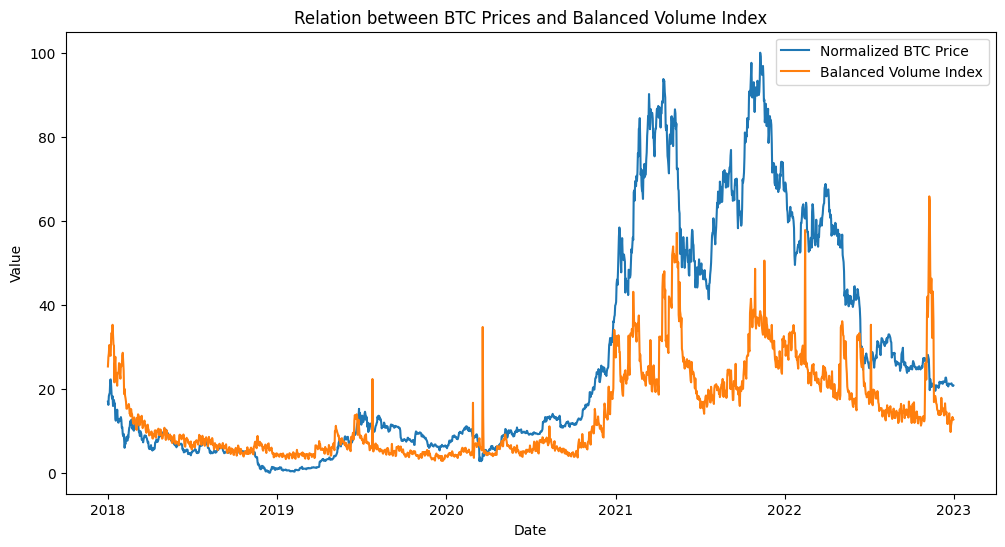

In [ ]:
plt.figure(figsize=(12, 6))

# Primo grafico
plt.plot(btc_price['Date'], normalized_btc)
plt.xlabel('Date')
#plt.ylabel('Price')
plt.title('Relation between BTC Prices and Balanced Volume Index')

# Secondo grafico
plt.plot(btc_price['Date'], balanced_volume_index)
plt.ylabel('Value')

plt.legend(['Normalized BTC Price', 'Balanced Volume Index'])
plt.show()


In [ ]:
correlation2 = np.corrcoef(balanced_volume_index, btc_price.Open.values)[0, 1]
print("The correlation between the bitcoin price and the new balanced index is equal to",round(correlation2, 2))

The correlation between the bitcoin price and the new balanced index is equal to 0.83


In [ ]:
final_df['balanced_volume_index'] = balanced_volume_index
final_df['volume_index'] = normalized_tweets.values

We can say that the correlation has improved a lot

## ***5. application of the Crypto fear and greed index to the sentiment index***

The Fear and Greed Index for cryptocurrencies is a tool that measures current crypto market sentiment based on several indicators. This index assigns a score from 0 to 100, where a low score indicates extreme fear and a high score indicates excessive greed. It can be useful because it provides investors with a quick overview of market participants' sentiment, helping them make informed decisions about cryptocurrencies. The data comes from the API of [Alternative](https://alternative.me/crypto/fear-and-greed-index/). The authors of this index use the following information to calculate the index:
1. Volatility (25 %): measuring the current volatility and max. drawdowns of bitcoin and compare it with the corresponding average values of the last 30 days and 90 days.
2. Market Momentum/Volume (25%): measuring the current volume and market momentum (again in comparison with the last 30/90 day average values) and put those two values togethergreedy / too bullish.
3. Social Media (15%): gather and count posts (on Twitter) on various hashtags for each coin and check how fast and how many interactions they receive in certain time frames
4. Surveys (15%) (currently paused): results of crypto poll from strawpoll.com
5. Dominance (10%): The dominance of a coin resembles the market cap share of the whole crypto market.
6. Trends (10%): Google Trends data for various Bitcoin related search queries.

Therefore, our idea is to apply this indicator to the previous VADER index

In [ ]:
f_g= pd.read_csv("/content/drive/MyDrive/fear.csv")
f_g['date'] = pd.to_datetime(f_g['date'])
f_g = f_g[f_g['date']< "01-01-2023"]
f_g = f_g.sort_values('date', ascending=True)

<ipython-input-163-413325105b66>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  f_g['date'] = pd.to_datetime(f_g['date'])


Since the data for the day 2018-01-01 is missing, to make the dataframe confrontables I ass that row with the same values of the next day

In [ ]:
f_g

,date,value,class
1975,2018-01-02,30,Fear
1947,2018-01-03,38,Fear
1916,2018-01-04,16,Extreme Fear
1889,2018-01-05,56,Greed
1858,2018-01-06,24,Extreme Fear
...,...,...,...
188,2022-12-27,27,Fear
187,2022-12-28,28,Fear
186,2022-12-29,28,Fear
185,2022-12-30,28,Fear


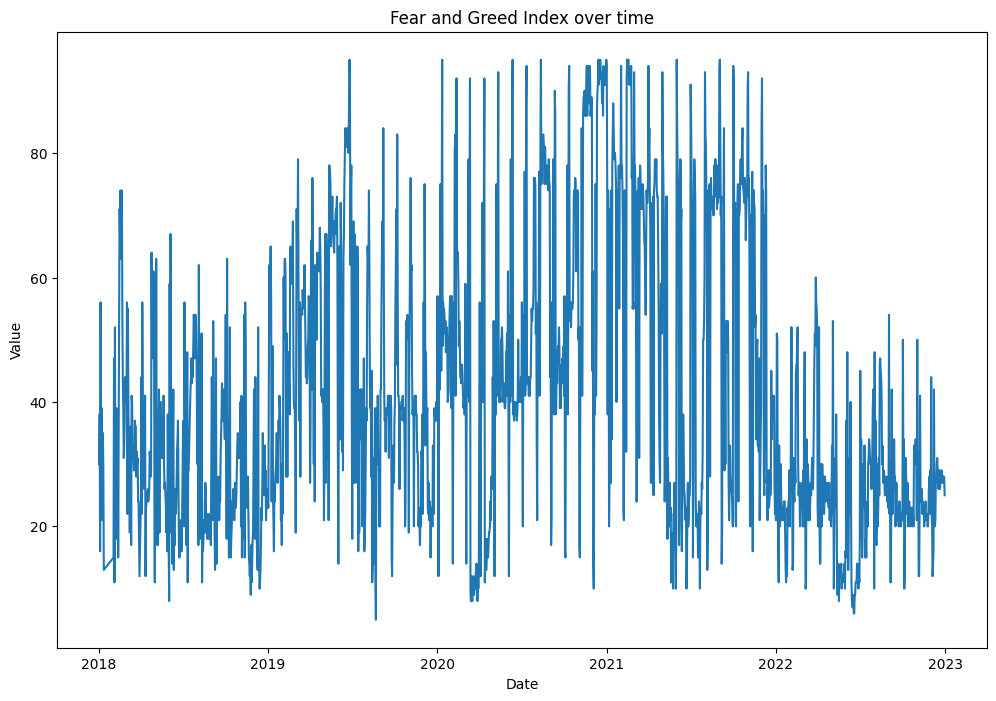

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(f_g['date'], f_g['value'])
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Fear and Greed Index over time')

plt.show()

In [ ]:
vader_index_df = vader_index.reset_index()
vader_index_df.columns = ['date', 'vader_comp']
vader_index_df

,date,vader_comp
0,2018-01-01,57.898243
1,2018-01-02,58.633798
2,2018-01-03,58.738566
3,2018-01-04,54.541731
4,2018-01-05,57.220443
...,...,...
1821,2022-12-27,58.933737
1822,2022-12-28,57.521939
1823,2022-12-29,58.524244
1824,2022-12-30,57.620619


In [ ]:
vader_index_df['date'] = pd.to_datetime(vader_index_df['date'])

# Convert the 'date' column in "f_g" to Timestamp
f_g['date'] = pd.to_datetime(f_g['date'])

In [ ]:
diff_dates = vader_index_df['date'][~vader_index_df['date'].isin(f_g['date'])]

Since for some days the fear and greed index was not calculated, we decided to still put the dates in the right column and put NA in the values. We did this to make it compatible with the vader index calculated earlier.

In [ ]:
new_rows = pd.DataFrame({'date': diff_dates, 'value': pd.NA, 'class': pd.NA})

# Aggiungi le nuove righe al DataFrame esistente
f_g = f_g.append(new_rows, ignore_index=True)

<ipython-input-168-8d2292066b85>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  f_g = f_g.append(new_rows, ignore_index=True)


In [ ]:
f_g = f_g.sort_values('date', ascending=True)
f_g

,date,value,class
1792,2018-01-01,<NA>,NaN
0,2018-01-02,30,Fear
1,2018-01-03,38,Fear
2,2018-01-04,16,Extreme Fear
3,2018-01-05,56,Greed
...,...,...,...
1787,2022-12-27,27,Fear
1788,2022-12-28,28,Fear
1789,2022-12-29,28,Fear
1790,2022-12-30,28,Fear


We now combine the fear and greed index and the vader into a single database. This will serve us to create a new index given by an average between the two values.

In [ ]:
merged_df = pd.concat([vader_index_df.set_index('date'), f_g.set_index('date')], axis=1, join='inner')

# Reset the index of the merged dataframe
merged_df = merged_df.reset_index()

# Convert the 'date' column back to datetime.date
merged_df['date'] = merged_df['date'].dt.date


merged_df['value']=merged_df['value'].fillna(merged_df['vader_comp'])
merged_df['average'] = merged_df['value'] * 0.2 + merged_df['vader_comp'] * 0.8
merged_df

,date,vader_comp,value,class,average
0,2018-01-01,57.898243,57.898243,NaN,57.898243
1,2018-01-02,58.633798,30.000000,Fear,52.907038
2,2018-01-03,58.738566,38.000000,Fear,54.590853
3,2018-01-04,54.541731,16.000000,Extreme Fear,46.833385
4,2018-01-05,57.220443,56.000000,Greed,56.976354
...,...,...,...,...,...
1821,2022-12-27,58.933737,27.000000,Fear,52.546990
1822,2022-12-28,57.521939,28.000000,Fear,51.617551
1823,2022-12-29,58.524244,28.000000,Fear,52.419395
1824,2022-12-30,57.620619,28.000000,Fear,51.696496


ince as can be seen from the graph the values of the fear and greed index are very variable from day to day, we decided to turn them into weekly frequency through a simple arithmetic average to make them smoother.

In [ ]:
smooth_fg = merged_df['value']
balanced_index_fg=[]
for i in range(0,260+1):

    limit1= values[i]
    limit2=values[i+1]
    a=smooth_fg[limit1: limit2].values
    mean_week = sum(a)/len(a)  # let's compute the mean Fear and Greed index for the week
    mean_week_list=[]
    for j in range(0,7):
        mean_week_list.append(mean_week) # we repeat the mean seven time, to make easier later the creation of the index

    balanced_index_fg.append(mean_week_list)

balanced_fg_index =  [item for sublist in balanced_index_fg for item in sublist]
balanced_fg_index.pop(-1) # we removed the last value since tha last groups have only 6 days

27.333333333333332

We create the new index where we give as weight 0.7 to the value of vader and 0.3 to the value of weekly fear and greed index

In [ ]:
merged_df['balanced_fg']=balanced_fg_index
merged_df['average_balanced'] = merged_df['balanced_fg'] * 0.3 + merged_df['vader_comp'] * 0.7
vader_balanced = merged_df[['date','average_balanced']]

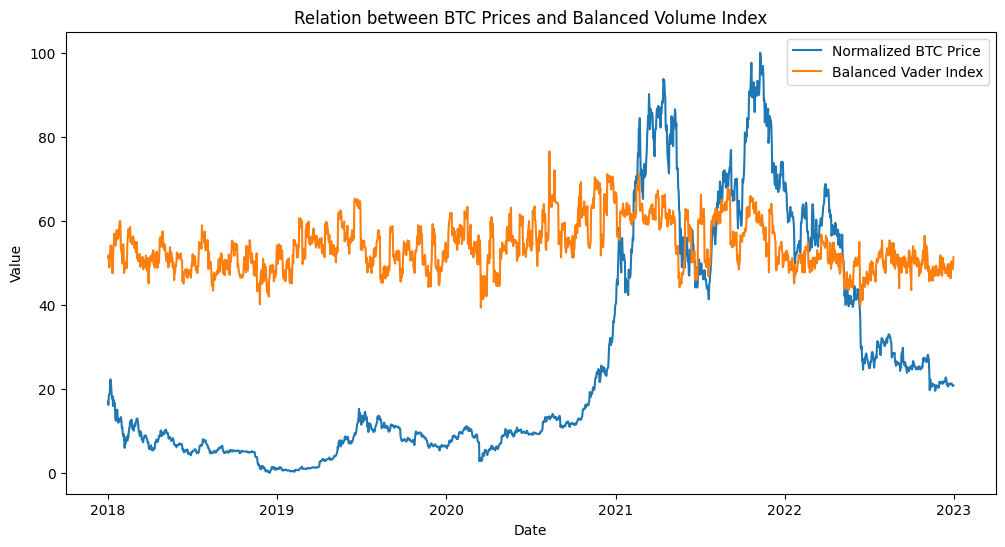

In [ ]:
plt.figure(figsize=(12, 6))

# Primo grafico
plt.plot(btc_price['Date'], normalized_btc)
plt.xlabel('Date')
#plt.ylabel('Price')
plt.title('Relation between BTC Prices and Balanced Volume Index')

# Secondo grafico
plt.plot(btc_price['Date'], vader_balanced.average_balanced)
plt.ylabel('Value')

plt.legend(['Normalized BTC Price', 'Balanced Vader Index'])
plt.show()

In [ ]:
correlation_vader_balanced = np.corrcoef(vader_balanced.average_balanced.values, btc_price.Open.values)[0, 1]
print("The correlation between the bitcoin price and the Vader index is equal to",round(correlation_vader_balanced, 2))

The correlation between the bitcoin price and the Vader index is equal to 0.33


The index and the price of bitcoin appear to be barely correlated, more or less the same level of the simple vader index. Looking at the graph it seems that before 2021 this index is not highly correlated with the price of bitcoin. let's try recalculating the correlation coefficient only with data from 2021 onward:

In [ ]:
final_df['balanced_vader_index']=vader_balanced['average_balanced']

In [ ]:
date_threshold = datetime.date.fromisoformat('2021-01-01')
vader_balanced_2123 = vader_balanced[vader_balanced['date'] < date_threshold]


date_threshold_btc = np.datetime64(date_threshold)
btc_2123 = btc_price[btc_price['Date'] < date_threshold_btc]
normalized_btc_2123 = btc_2123['Open']
scaler = MinMaxScaler()
normalized_btc_2123 = scaler.fit_transform(normalized_btc_2123.values.reshape(-1, 1))
normalized_btc_2123 = pd.Series(normalized_btc_2123.flatten())*100

In [ ]:
correlation_vader_balanced = np.corrcoef(vader_balanced_2123.average_balanced.values, normalized_btc_2123.values)[0, 1]
print("The correlation between the bitcoin price and the Vader index is equal to",round(correlation_vader_balanced, 2))

The correlation between the bitcoin price and the Vader index is equal to 0.59


So if we consider only the data for the last two years, the correlation goes up a lot coming to quite significant values. in our opinion, the correlation improves because, both the sample of tweets becomes much larger, and because probably the fear and greed index is being calculated with better  techniques.

In [ ]:
final_df.to_csv('df_for_predictions.csv', index=False)

# **FORECASTING EXERCISE**

## **Settings**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
import xgboost as xgb

In [ ]:
final_df = pd.read_csv("/content/drive/MyDrive/df_for_predictions.csv")
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,index_transformers_max_man_weighted,index_transformers_max_pro_weighted,index_transformers_min_man_weighted,index_transformers_min_pro_weighted,index_word2vec,vader_index,balanced_volume_index,volume_index,balanced_vader_index
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,13657.200195,10291200000,NaN,NaN,NaN,NaN,0.014065,57.898243,25.296209,6.992418,51.195838
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,14982.099609,16846600192,NaN,NaN,NaN,NaN,0.018167,58.633798,27.500646,11.401292,51.710726
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,15201.000000,16871900160,NaN,NaN,NaN,NaN,0.019653,58.738566,28.441393,13.282786,51.784064
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,15599.200195,21783199744,NaN,NaN,NaN,NaN,0.022976,54.541731,30.393092,17.186184,48.846279
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,17429.500000,23840899072,NaN,NaN,NaN,NaN,0.011172,57.220443,28.666049,13.732098,50.721378


In [ ]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)

  return {"mae": np.mean(mae.numpy()),
          "mse": np.mean(mse.numpy()),
          "rmse": np.mean(rmse.numpy())}

# ***1. LSTM***

In [ ]:
df_train = final_df[(final_df["Date"].dt.year == 2021)]
df_test = final_df[(final_df["Date"].dt.year == 2022) & (final_df["Date"].dt.month <= 2)]

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, activation='relu', input_shape=(1, 1)))
lstm_model.add(Dense(units=1))

## **VADER INDEX**

### ***Unbalanced Vader Index***

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
vader_train = scaler.fit_transform(df_train['vader_index'].values.reshape(-1, 1))
price_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
vader_test = scaler.transform(df_test['vader_index'].values.reshape(-1, 1))
price_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
# LSTM model
lstm_model.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae"])
lstm_model.fit(vader_train, price_train, epochs=100, batch_size=32)

In [ ]:
lstm_forecast_vader = lstm_model.predict(vader_test)
lstm_forecast_vader = tf.squeeze(lstm_forecast_vader)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# Evaluate preds
results_vader = evaluate_preds(y_true=tf.squeeze(price_test), y_pred=lstm_forecast_vader)
results_vader

{'mae': 0.3815389, 'mse': 0.20326106, 'rmse': 0.45084482}

### ***Balanced Vader Index***

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
vader_balanced_train = scaler.fit_transform(df_train['balanced_vader_index'].values.reshape(-1, 1))
price_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
vader_balanced_test = scaler.transform(df_test['balanced_vader_index'].values.reshape(-1, 1))
price_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
# LSTM model
lstm_model.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae"])
lstm_model.fit(vader_balanced_train, price_train, epochs=100, batch_size=32)

In [ ]:
lstm_forecast_vader_balanced = lstm_model.predict(vader_balanced_test)
lstm_forecast_vader_balanced = tf.squeeze(lstm_forecast_vader_balanced)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# Evaluate preds
results_vader_balanced = evaluate_preds(y_true=tf.squeeze(price_test), y_pred=lstm_forecast_vader_balanced)
results_vader_balanced

{'mae': 0.4152548, 'mse': 0.23089021, 'rmse': 0.48051035}

## **VOLUME INDEX**

### ***Volume Index***

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
volume_train = scaler.fit_transform(df_train['volume_index'].values.reshape(-1, 1))
price_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
volume_test = scaler.transform(df_test['volume_index'].values.reshape(-1, 1))
price_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
# LSTM model
lstm_model.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae"])
lstm_model.fit(volume_train, price_train, epochs=100, batch_size=32)

In [ ]:
lstm_forecast_volume = lstm_model.predict(volume_test)
lstm_forecast_volume = tf.squeeze(lstm_forecast_volume)

2/2 [==============================] - 0s 4ms/step


In [ ]:
# Evaluate preds
results_volume = evaluate_preds(y_true=tf.squeeze(price_test), y_pred=lstm_forecast_volume)
results_volume

{'mae': 0.38788325, 'mse': 0.2082741, 'rmse': 0.45637056}

### ***Balanced Volume Index***

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
volume_balanced_train = scaler.fit_transform(df_train['balanced_volume_index'].values.reshape(-1, 1))
price_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
volume_balanced_test = scaler.transform(df_test['balanced_volume_index'].values.reshape(-1, 1))
price_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
# LSTM model
lstm_model.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae"])
lstm_model.fit(volume_balanced_train, price_train, epochs=100, batch_size=32)

In [ ]:
lstm_forecast_volume_balanced = lstm_model.predict(volume_balanced_test)
lstm_forecast_volume_balanced = tf.squeeze(lstm_forecast_volume_balanced)

2/2 [==============================] - 0s 7ms/step


In [ ]:
# Evaluate preds
results_volume_balanced = evaluate_preds(y_true=tf.squeeze(price_test), y_pred=lstm_forecast_volume_balanced)
results_volume_balanced

{'mae': 0.39863038, 'mse': 0.21696275, 'rmse': 0.4657926}

## **WORD2VEC INDEX**

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
word2vec_train = scaler.fit_transform(df_train['index_word2vec'].values.reshape(-1, 1))
price_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
word2vec_test = scaler.transform(df_test['index_word2vec'].values.reshape(-1, 1))
price_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
# LSTM model
lstm_model.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae"])
lstm_model.fit(word2vec_train, price_train, epochs=100, batch_size=32)

In [ ]:
lstm_forecast_word2vec = lstm_model.predict(word2vec_test)
lstm_forecast_word2vec = tf.squeeze(lstm_forecast_word2vec)

2/2 [==============================] - 0s 8ms/step


In [ ]:
# Evaluate preds
results_word2vec = evaluate_preds(y_true=tf.squeeze(price_test), y_pred=lstm_forecast_word2vec)
results_word2vec

{'mae': 0.35832316, 'mse': 0.18502337, 'rmse': 0.43014342}

# **2. XGBoost**

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor()

In [ ]:
# split in train and test
df_train = final_df[(final_df["Date"].dt.year == 2021)]
df_test = final_df[(final_df["Date"].dt.year == 2022) & (final_df["Date"].dt.month <= 2)]

## **VADER INDEX**

### ***Unbalanced Vader Index***

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
vader_train = scaler.fit_transform(df_train['vader_index'].values.reshape(-1, 1))
y_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
vader_test = scaler.transform(df_test['vader_index'].values.reshape(-1, 1))
y_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
xgb.fit(vader_train, y_train)

In [ ]:
# Evaluate preds
predictions_vader = xgb.predict(vader_test)
results_vader = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=tf.squeeze(predictions_vader))
results_vader

{'mae': 0.24048845, 'mse': 0.09162883, 'rmse': 0.30270255}

### ***Balanced Vader Index***

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
vader_train = scaler.fit_transform(df_train['balanced_vader_index'].values.reshape(-1, 1))
y_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
vader_test = scaler.transform(df_test['balanced_vader_index'].values.reshape(-1, 1))
y_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
xgb.fit(vader_train, y_train)

In [ ]:
# Evaluate preds
predictions_balanced_vader = xgb.predict(vader_test)
results_balanced_vader = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=tf.squeeze(predictions_balanced_vader))
results_balanced_vader

{'mae': 0.23372589, 'mse': 0.073732294, 'rmse': 0.27153692}

## **VOLUME INDEX**

### ***Unbalanced Vader Index***

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
volume_train = scaler.fit_transform(df_train['volume_index'].values.reshape(-1, 1))
y_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
volume_test = scaler.transform(df_test['volume_index'].values.reshape(-1, 1))
y_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
xgb.fit(volume_train, y_train)

In [ ]:
# Evaluate preds
predictions_volume = xgb.predict(volume_test)
results_volume = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=tf.squeeze(predictions_volume))
results_volume

{'mae': 0.38260484, 'mse': 0.20409723, 'rmse': 0.4517712}

### ***Balanced Vader Index***

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
volume_balanced_train = scaler.fit_transform(df_train['balanced_volume_index'].values.reshape(-1, 1))
y_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
volume_balanced_test = scaler.transform(df_test['balanced_volume_index'].values.reshape(-1, 1))
y_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
xgb.fit(volume_balanced_train, y_train)

In [ ]:
# Evaluate preds
predictions_volume_balanced = xgb.predict(volume_balanced_test)
results_volume_balanced = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=tf.squeeze(predictions_volume_balanced))
results_volume_balanced

{'mae': 0.3522052, 'mse': 0.18025501, 'rmse': 0.42456448}

## **WORD2VEC**

In [ ]:
# Preprocess the Vader Index and Bitcoin price
scaler = MinMaxScaler()
word2vec_train = scaler.fit_transform(df_train['index_word2vec'].values.reshape(-1, 1))
y_train = scaler.fit_transform(df_train['Open'].values.reshape(-1, 1))
# Preprocess the Vader Index for testing data
word2vec_test = scaler.transform(df_test['index_word2vec'].values.reshape(-1, 1))
y_test = scaler.fit_transform(df_test['Open'].values.reshape(-1, 1))

In [ ]:
xgb.fit(word2vec_train, y_train)

In [ ]:
# Evaluate preds
predictions_word2vec = xgb.predict(word2vec_test)
results_word2vec = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=tf.squeeze(predictions_word2vec))
results_word2vec

{'mae': 0.4432075, 'mse': 0.25187644, 'rmse': 0.5018729}

# **3. ARIMA**

In [ ]:
final_df =  pd.read_csv("C:\\Users\\Alessandro\\Downloads\\df_for_predictions.csv")
final_df['Date'] = pd.to_datetime(final_df['Date'])

### ARIMA(0,1,0) with exogenous variables (Indexes)

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [ ]:
columns = ['balanced_vader_index', 'balanced_volume_index', 'volume_index', 'vader_index', 'index_word2vec']

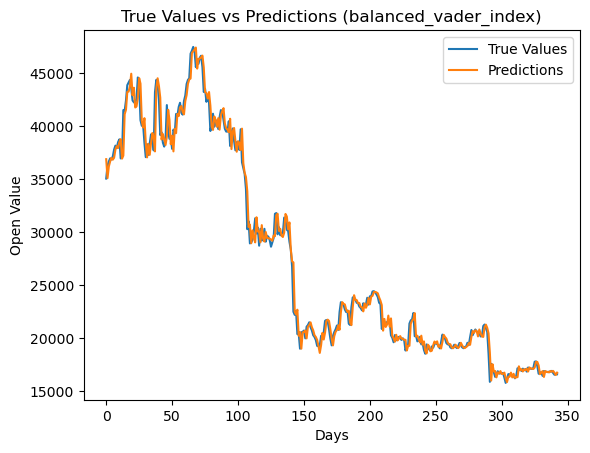

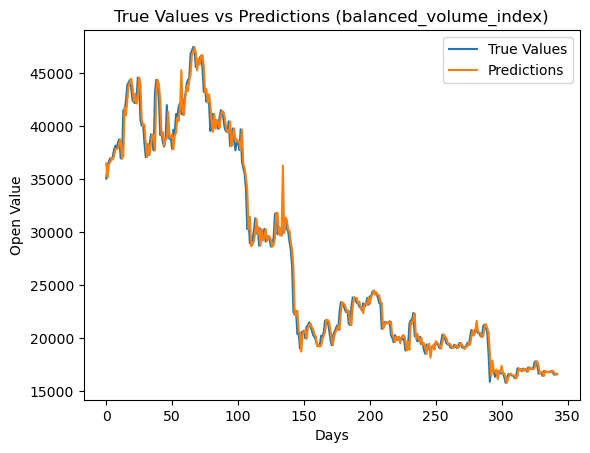

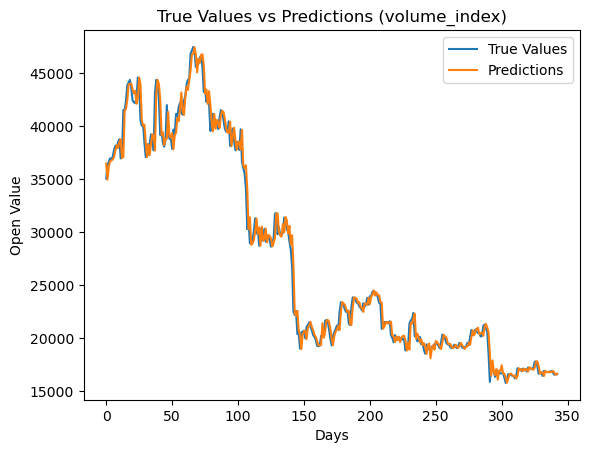

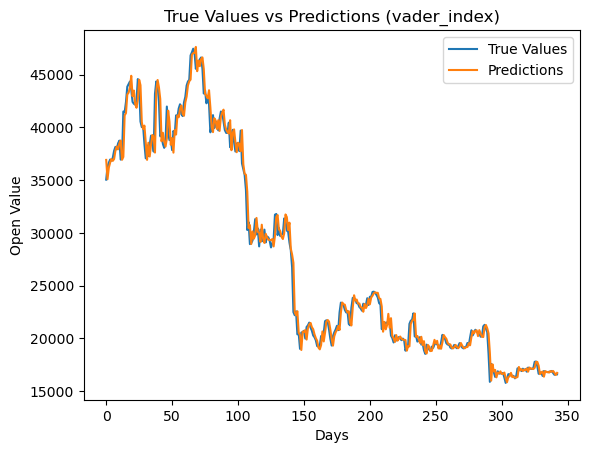

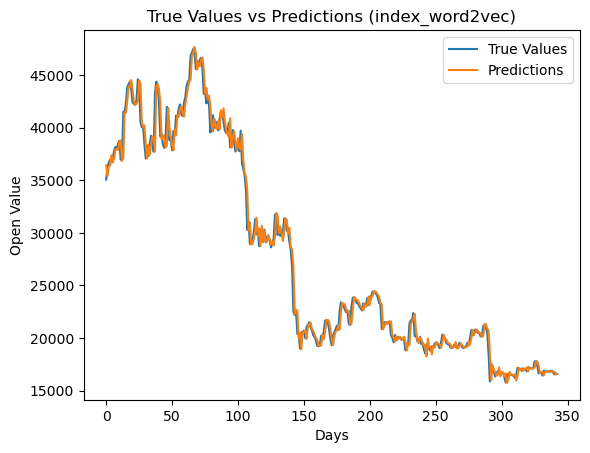

In [ ]:
final_df = final_df[final_df['Date'] > "2022-01-01"]
columns = ['balanced_vader_index', 'balanced_volume_index', 'volume_index', 'vader_index', 'index_word2vec']
window_size = 21
mae_dict = {}

for column in columns:
    predictions = []

    for i in range(len(final_df) - window_size):
        train_df = final_df[i:i+window_size]
        test_df = final_df[i+window_size:i+window_size+1]

        train_X = train_df[column].values.reshape(-1, 1)
        train_Y = train_df['Open'].values
        test_X = test_df[column].values.reshape(-1, 1)

        model = ARIMA(train_Y, order=(0, 1, 0), exog=train_X)
        model_fit = model.fit()

        forecast = model_fit.forecast(steps=1, exog=test_X)
        predicted_value = forecast[0]
        predictions.append(predicted_value)

    true_values = final_df['Open'].values[window_size:]
    mae = mean_absolute_error(true_values, predictions)

    mae_dict[column] = mae

    plt.plot(true_values, label='True Values')
    plt.plot(predictions, label='Predictions')
    plt.xlabel('Days')
    plt.ylabel('Open Value')
    plt.title(f'True Values vs Predictions ({column})')
    plt.legend()
    plt.show()

In [ ]:
mae_dict

{'balanced_vader_index': 661.9163488815817,
 'balanced_volume_index': 688.3169231409479,
 'volume_index': 677.4388792314811,
 'vader_index': 669.9238645982717,
 'index_word2vec': 650.034383890547}

### Vanilla ARIMA(0,1,0)

In [ ]:
final_df = final_df[final_df['Date'] > "2022-01-01"]
window_size = 21

predictions = []

for i in range(len(final_df) - window_size):
    train_df = final_df[i:i+window_size]
    test_df = final_df[i+window_size:i+window_size+1]

    train_Y = train_df['Open'].values
    test_Y = test_df['Open'].values

    model = ARIMA(train_Y, order=(0, 1, 0))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=1)
    predicted_value = forecast[0]
    predictions.append(predicted_value)

true_values = final_df['Open'].values[window_size:]
mae = mean_absolute_error(true_values, predictions)


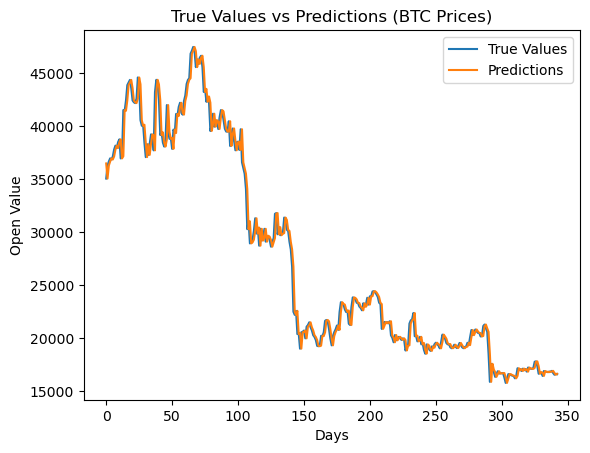

In [ ]:
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Days')
plt.ylabel('Open Value')
plt.title('True Values vs Predictions (BTC Prices)')
plt.legend()
plt.show()

In [ ]:
print(mae)

640.3416830437318
